# <span style="color:pink">1.Introduction</span>

### This notebook aims to predict the total box office for movies using the Metacritic dataset. The process includes data exploration, cleaning, feature engineering, and implementing machine learning models for prediction.


# <span style="color:pink">2.Loading and exploring the data</span>

In [1]:
import pandas as pd
import numpy as np 
import re
from IPython.display import display
import random
from typing import List
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import torch
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import torch.nn as nn
import torch.optim as optim
import shap
import dice_ml
from dice_ml.utils import helpers
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

/opt/anaconda3/envs/introduction/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
meta_clean = pd.read_excel('/Users/parisa/Desktop/AI/Final_Assignment/metaClean.xlsx')
meta_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11364 entries, 0 to 11363
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   url        11364 non-null  object        
 1   title      11364 non-null  object        
 2   studio     11014 non-null  object        
 3   rating     10297 non-null  object        
 4   runtime    11109 non-null  float64       
 5   cast       7662 non-null   object        
 6   director   11350 non-null  object        
 7   genre      11344 non-null  object        
 8   summary    5467 non-null   object        
 9   awards     4387 non-null   object        
 10  metascore  11364 non-null  int64         
 11  userscore  9259 non-null   float64       
 12  RelDate    11364 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 1.1+ MB


In [3]:
sales= pd.read_excel("/Users/parisa/Desktop/AI/Final_Assignment/sales.xlsx")
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30612 entries, 0 to 30611
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      30612 non-null  int64  
 1   release_date              30612 non-null  object 
 2   title                     30604 non-null  object 
 3   genre                     28908 non-null  object 
 4   international_box_office  21575 non-null  float64
 5   domestic_box_office       11884 non-null  float64
 6   worldwide_box_office      21575 non-null  float64
 7   production_budget         4480 non-null   float64
 8   Unnamed: 8                0 non-null      float64
 9   opening_weekend           10929 non-null  float64
 10  theatre_count             10963 non-null  float64
 11  avg run per theatre       10952 non-null  float64
 12  runtime                   24559 non-null  float64
 13  keywords                  12517 non-null  object 
 14  creati

### <span style="color:pink">2.1 Dropping unnecessary columns</span>


In [4]:
#Parisa
# Drop the columns that cannot be used as the pre-release features
# Drop genre from metaclean becuase we have it in sales
columns_to_drop = ['genre', 'awards', 'metascore', 'userscore', 'summary']
meta_clean = meta_clean.drop(columns=columns_to_drop, errors='ignore')

# Verify the changes
print("Remaining columns after dropping unnecessary ones:")
print(meta_clean.columns)

#Arezoo
#Drop the columns that cannot be used as the pre-release features
columns_to_drop = ["Unnamed: 8", "theatre_count", "avg run per theatre", "opening_weekend", "runtime", "release_date"]
sales = sales.drop(columns=[col for col in columns_to_drop if col in sales.columns], errors='ignore')
print(sales.columns)

Remaining columns after dropping unnecessary ones:
Index(['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director',
       'RelDate'],
      dtype='object')
Index(['year', 'title', 'genre', 'international_box_office',
       'domestic_box_office', 'worldwide_box_office', 'production_budget',
       'keywords', 'creative_type', 'url'],
      dtype='object')


### <span style="color:pink">2.2 Box Office</span>


#### Steps to handle the box office columns["international_box_office","domestic_box_office", "worldwide_box_office"] which is our target columns
- Fill missing values:
    Replace NaN values in the three columns with 0.
- ⁠Create a column named total_box_office:
    If worldwide_box_office > 0, use it as the total_box_office. Otherwise, calculate the sum of domestic_box_office and international_box_office.

In [5]:
#Arezoo 

# Fill missing values with 0
sales["domestic_box_office"] = sales["domestic_box_office"].fillna(0)
sales["international_box_office"] = sales["international_box_office"].fillna(0)
sales["worldwide_box_office"] = sales["worldwide_box_office"].fillna(0)

#Create total_box_office column
sales["total_box_office"] = sales.apply(
    lambda row: row["worldwide_box_office"]
    if row["worldwide_box_office"] > 0
    else row["domestic_box_office"] + row["international_box_office"],
    axis=1
)
# show the updated dataframe with the new column
print("Sample rows with total_box_office feature:")
display(sales[["domestic_box_office", "international_box_office", "worldwide_box_office", "total_box_office"]].head())

# we can remove the previous three columns
sales.drop(columns=["domestic_box_office", "international_box_office", "worldwide_box_office"], inplace=True)

Sample rows with total_box_office feature:


,domestic_box_office,international_box_office,worldwide_box_office,total_box_office
0,0.0,76576.0,76576.0,76576.0
1,10965209.0,6900000.0,17865209.0,17865209.0
2,378562.0,0.0,0.0,378562.0
3,0.0,0.0,0.0,0.0
4,41227069.0,4833792.0,46060861.0,46060861.0


---

# <span style="color:pink">3.Exploratory Data Analysis (EDA)</span>

### <span style="color:pink">3.1 Creating the 'title_year' -metaclean, sales</span>
## Reason: Because when we merged on title_year, we got thousand more rows
#### Replace the title column by extracting titles from the URL and appending the release year


In [6]:
#parisa
# Extract the year from the 'RelDate' column and create a new 'year' column
meta_clean['year'] = pd.to_datetime(meta_clean['RelDate']).dt.year
# Create a new column by concatenating 'title' and 'year' without a space
meta_clean['title_year'] = meta_clean['title'] + meta_clean['year'].astype(str)

# Display the first few rows of the updated dataset
print(meta_clean[['title', 'year', 'title_year']].head())

# Julian
# Create a new column by concatenating 'title' and 'year' without a space
sales['title_year'] = sales['title'].astype(str) + sales['year'].astype(str)

# Display the first few rows of the updated dataset
print(sales[['title', 'year', 'title_year']].head())

                            

                   title  year                 title_year
0  !Women Art Revolution  2011  !Women Art Revolution2011
1    10 Cloverfield Lane  2016    10 Cloverfield Lane2016
2       10 Items or Less  2006       10 Items or Less2006
3               10 Years  2012               10 Years2012
4       100 Bloody Acres  2013       100 Bloody Acres2013
                 title  year               title_year
0         Bakha Satang  2000         Bakha Satang2000
1            Antitrust  2001            Antitrust2001
2             Santitos  2000             Santitos2000
3  Frank McKlusky C.I.  2002  Frank McKlusky C.I.2002
4   A Walk to Remember  2002   A Walk to Remember2002


In [7]:
# Ghazaleh
#Drop the columns that cannot be used as the pre-release features
columns_to_drop = ["url", "title"]
sales = sales.drop(columns=[col for col in columns_to_drop if col in sales.columns], errors='ignore')
print(sales.columns)

Index(['year', 'genre', 'production_budget', 'keywords', 'creative_type',
       'total_box_office', 'title_year'],
      dtype='object')


In [8]:
meta_clean.drop(columns='year', errors='ignore', inplace=True)


In [9]:
meta_clean.columns

Index(['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director',
       'RelDate', 'title_year'],
      dtype='object')

### <span style="color:pink">3.2 Merge metaClean with sales</span>


In [10]:
# All of the group members
# Perform an inner merge on the 'title_year' column
merged_data = pd.merge(meta_clean, sales, on='title_year', how='inner')

print(f"Merged data saved to {merged_data}")


Merged data saved to                                                     url                title  \
0     https://www.metacritic.com/movie/10-cloverfiel...  10 Cloverfield Lane   
1             https://www.metacritic.com/movie/10-years             10 Years   
2     https://www.metacritic.com/movie/100-bloody-acres     100 Bloody Acres   
3           https://www.metacritic.com/movie/1001-grams           1001 Grams   
4       https://www.metacritic.com/movie/102-dalmatians       102 Dalmatians   
...                                                 ...                  ...   
7750         https://www.metacritic.com/movie/zoolander            Zoolander   
7751       https://www.metacritic.com/movie/zoolander-2          Zoolander 2   
7752              https://www.metacritic.com/movie/zoom                 Zoom   
7753         https://www.metacritic.com/movie/zoom-2016                 Zoom   
7754          https://www.metacritic.com/movie/zootopia             Zootopia   

                  

In [11]:
# get more information about the dataset
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7755 entries, 0 to 7754
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   url                7755 non-null   object        
 1   title              7755 non-null   object        
 2   studio             7568 non-null   object        
 3   rating             7210 non-null   object        
 4   runtime            7600 non-null   float64       
 5   cast               5562 non-null   object        
 6   director           7746 non-null   object        
 7   RelDate            7755 non-null   datetime64[ns]
 8   title_year         7755 non-null   object        
 9   year               7755 non-null   int64         
 10  genre              7423 non-null   object        
 11  production_budget  3420 non-null   float64       
 12  keywords           5906 non-null   object        
 13  creative_type      7125 non-null   object        
 14  total_bo

In [12]:
# describe the numerical columns of dataset
merged_data.describe()

,runtime,year,production_budget,total_box_office
count,7600.000000,7755.000000,3.420000e+03,7.755000e+03
mean,102.257368,2010.806705,4.061028e+07,5.234102e+07
std,18.757140,6.043575,4.796617e+07,1.483094e+08
min,31.000000,2000.000000,7.000000e+03,0.000000e+00
25%,91.000000,2006.000000,1.000000e+07,4.851900e+04
50%,99.000000,2011.000000,2.400000e+07,1.188194e+06
75%,110.000000,2016.000000,5.000000e+07,3.506688e+07
max,808.000000,2021.000000,4.000000e+08,2.845900e+09


### <span style="color:pink">3.3 Check for duplicates</span>


In [13]:
#Arezoo
#Check for duplicates
print("\n Number of duplicates")
merged_data["title_year"].duplicated().sum()


 Number of duplicates


19

In [14]:
# Drop duplicates rows based on the "title_year" column
merged_data = merged_data.drop_duplicates(subset=["title_year"], keep="first")

### <span style="color:pink">3.4 Check for negative values</span>


In [15]:
# Parisa
# Check if 'runtime' and 'production_budget' have negative value
if 'runtime' in sales.columns and 'production_budget' in sales.columns:
    runtime_negative_count = (sales['runtime'] <= 0).sum()
    budget_negative_count = (sales['production_budget'] <= 0).sum()
    
    # Print the results
    print(f"Number of rows with non-positive runtime: {runtime_negative_count}")
    print(f"Number of rows with non-positive production_budget: {budget_negative_count}")
else:
    print("One or both of the columns 'runtime' and 'production_budget' are missing.")


One or both of the columns 'runtime' and 'production_budget' are missing.


### <span style="color:pink">3.5 KNN IMPUTING FOR PRODUCTION_BUDGET</span>


##### Due to 46% of the values being missing in the production_budget column, using the mean or median to replace the missing values is not ideal. This approach oversimplifies the data and ignores the relationships between production_budget and other features, such as `genre`, `studio`, `run_time` and `director`.

##### To address this, we use KNN Imputation, which predicts missing values based on the "nearest neighbors" in the dataset. To ensure the optimal number of neighbors (K) is chosen, we apply GridSearch with cross-validation. GridSearch systematically tests different values of K and selects the one that minimizes the error (e.g., Mean Squared Error), making the imputation more reliable and accurate.
##### Domain Knowledge for Feature Selection
##### Genre: Different genres (e.g., action, sci-fi) on average have higher budgets than other genres (e.g., comedy). 
##### Director: Well-known directors can attract larger budgets.
##### Studio: Large studios (e.g., Warner Bros, Disney) have more financial resources compared to smaller, independent studios.  
##### Runtime: Films with longer runtimes typically require larger budgets due to higher production and post-production costs.

In [16]:
missing_percentage = merged_data['production_budget'].isnull().mean() * 100

print(f"Percentage missing values in 'production_budget': {missing_percentage:.2f}%")

Percentage missing values in 'production_budget': 55.80%


In [17]:
# # Import the necessary libraries
# import pandas as pd
# import numpy as np
# from sklearn.impute import KNNImputer
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error

# # Prepare the dataset
# features = ['genre', 'runtime', 'director', 'studio']
# target = 'production_budget'

# # Create a subset with only relevant columns
# data = merged_data[features + [target]]

# # One-hot encoding for categorical columns
# data_encoded = pd.get_dummies(data, columns=['genre', 'director', 'studio'], drop_first=True)

# # Separate features (X) and target (y)
# X_missing = data_encoded.drop(columns=[target])
# y_missing = data_encoded[target]

# # Train-test split
# X_train, X_val, y_train, y_val = train_test_split(X_missing, y_missing, test_size=0.2, random_state=42)

# # Create the KNN imputer pipeline
# knn_imputer = KNNImputer()
# pipeline = Pipeline([('imputer', knn_imputer)])

# # GridSearchCV to find the best K
# param_grid = {'imputer__n_neighbors': [3, 5, 7, 9, 11]}
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# # Retrieve the best K
# best_k = grid_search.best_params_['imputer__n_neighbors']
# print("Best K:", best_k)
# print("Best score (MSE):", -grid_search.best_score_)

# # Apply KNN-imputation with the best K
# imputer = KNNImputer(n_neighbors=best_k)
# data_encoded[target] = imputer.fit_transform(data_encoded.drop(columns=[target]))

# # Check if missing values have been filled
# print("Number of missing values in 'production_budget':", data_encoded[target].isnull().sum())

# # Update the original dataset with the imputed values
# merged_data['production_budget'] = data_encoded[target]

In [18]:
# # Julian 
# # Filter out rows with NaN or infinite values in 'production_budget' and 'total_box_office'
# filtered_data = merged_data[
#     merged_data[['production_budget', 'total_box_office']].applymap(np.isfinite).all(axis=1)
# ]

# # Calculate Pearson correlation on the filtered data
# correlation, p_value = pearsonr(filtered_data['production_budget'], filtered_data['total_box_office'])

# # Print the results
# print(f"Pearson Correlation between Production Budget and Total Box Office: {correlation:.3f}, P-value: {p_value:.3e}")

# # Create a heatmap for the correlation matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(
#     filtered_data[['production_budget', 'total_box_office']].corr(),
#     annot=True,
#     cmap='coolwarm',
#     fmt=".2f"
# )
# plt.title("Correlation Matrix: Production Budget vs Total Box Office")
# plt.show()


### <span style="color:pink">3.6 Check null values in: Production_budget, runtime, box_office</span>

In [19]:
# All of the team members
budget_missing_count = merged_data['production_budget'].isna().sum()
runtime_missing_count = merged_data['runtime'].isna().sum()
box_office_missing_count = merged_data['total_box_office'].isna().sum()
print(f"budget_missing_count Missing values before replacement: {budget_missing_count}")
print(f"runtime_missing_count Missing values before replacement: {runtime_missing_count}")
print(f"box_office_missing_count Missing values before replacement: {box_office_missing_count}")


a = merged_data['director'].isna().sum()
b = merged_data['cast'].isna().sum()
c = merged_data['studio'].isna().sum()

print(f"a: {budget_missing_count}")
print(f"b: {runtime_missing_count}")
print(f"c: {box_office_missing_count}")


budget_missing_count Missing values before replacement: 4317
runtime_missing_count Missing values before replacement: 155
box_office_missing_count Missing values before replacement: 0
a: 4317
b: 155
c: 0


## <span style="color:pink">3.7 Visualizing </span>


- To begin the EDA, we will focus on a single variable, 'total_box_ofiice', because this is the target for our ML models.
- ⁠what are independent and dependent features/labels in the dataset?
- ⁠Is the label categorical or numerical?

In [20]:
# Calculate the dependant and independant features
dependent_feature = ["total_box_office"]
independent_features = [col for col in merged_data.columns if col != dependent_feature]
print(f"Target: {dependent_feature}")
print(f"Independent features: {independent_features}")

Target: ['total_box_office']
Independent features: ['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director', 'RelDate', 'title_year', 'year', 'genre', 'production_budget', 'keywords', 'creative_type', 'total_box_office']


In [21]:
if  merged_data["total_box_office"].dtype in ["int64", "float64"]:
    print("The dependent feature is Numerical.")
else:
    print("The dependent feature is Categorical.")

The dependent feature is Numerical.


### Conclusion: 
- ⁠The dependent feature, total box office, is numerical with the data type of float. ⁠
- This indicates that we are dealing with regression problem, as the target variable is continuous.

### Calculate the quartiles for box_office

### We will plot both box office and log-transformed box office to reduce the skewness in the visualizations. In this way we can understand the overall distribution.


Min box office: $0.00
Q1 is: $48,586.50
Median or Q2 is: $1,204,234.50
Q3 is: $35,146,192.25
Max box office: $2,845,899,541.00


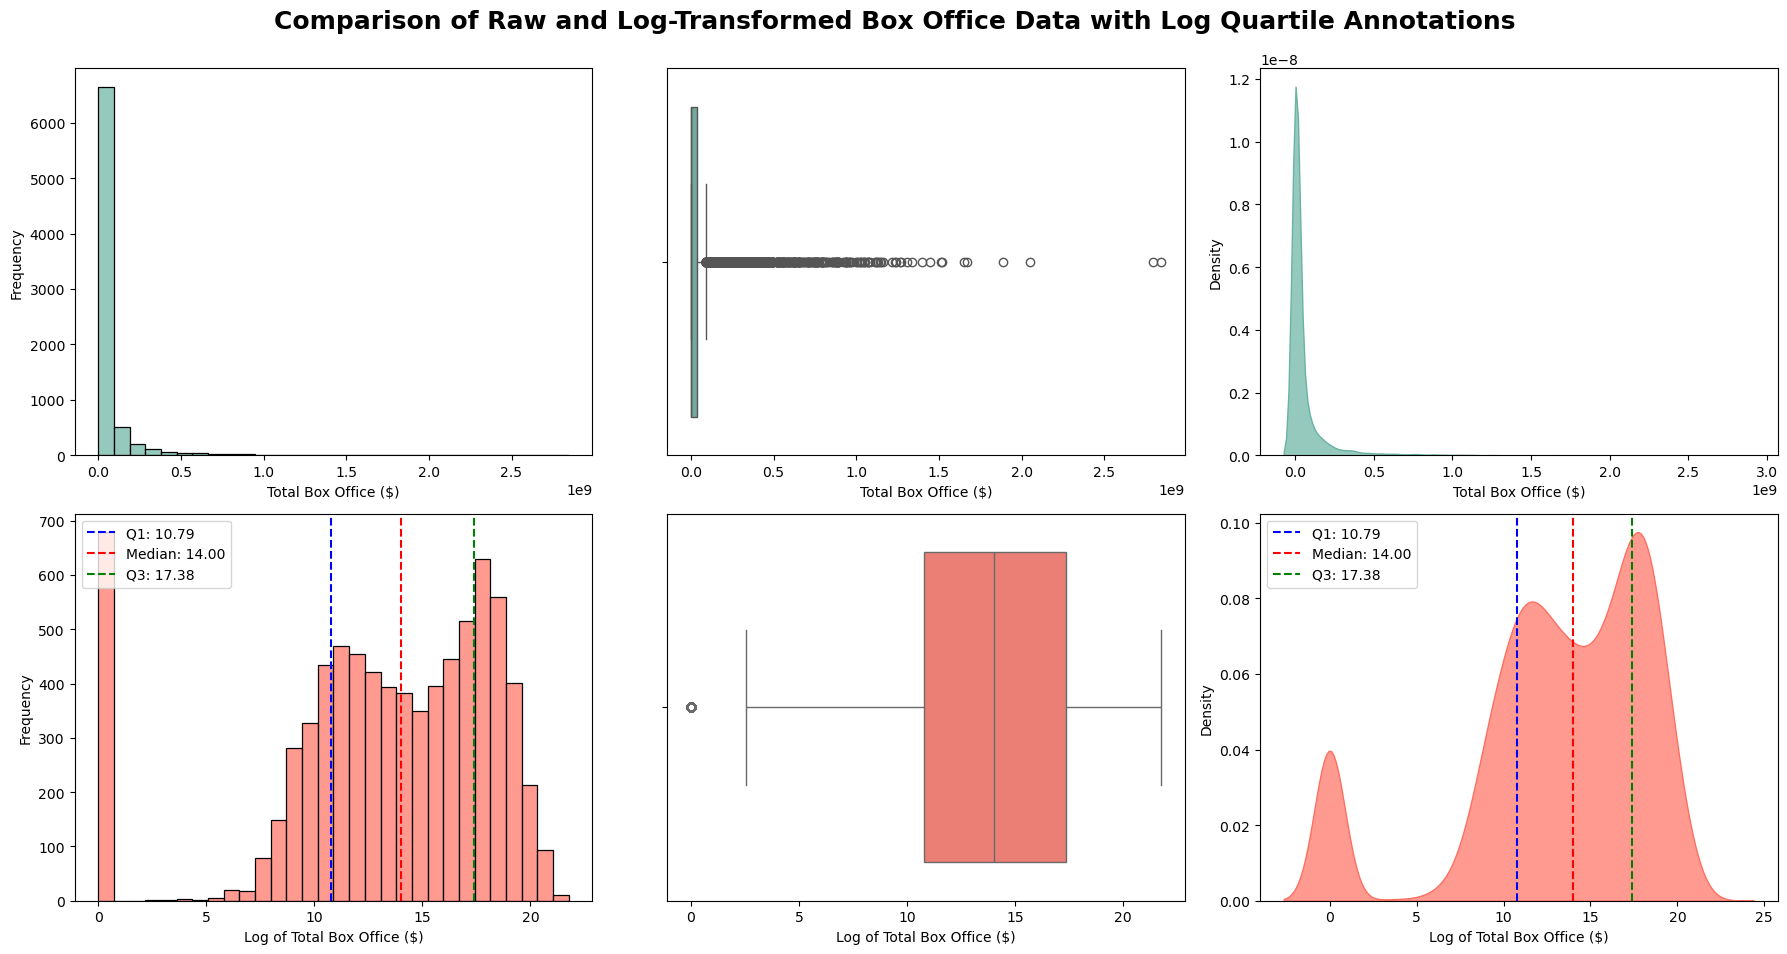

In [22]:
# Arezoo
# Calculate min, max, and quartiles for raw data
min_val = merged_data["total_box_office"].min()
q1 = np.percentile(merged_data["total_box_office"], 25)
median = np.percentile(merged_data["total_box_office"], 50)
q3 = np.percentile(merged_data["total_box_office"], 75)
max_val = merged_data["total_box_office"].max()

print(f"Min box office: ${min_val:,.2f}")
print(f"Q1 is: ${q1:,.2f}")
print(f"Median or Q2 is: ${median:,.2f}")
print(f"Q3 is: ${q3:,.2f}")
print(f"Max box office: ${max_val:,.2f}")

# log-transform the box office data
merged_data["log_box_office"] = np.log1p(merged_data["total_box_office"])  

# calculate Quartiles for log-transformed data
q1_log, median_log, q3_log = np.percentile(merged_data["log_box_office"].dropna(), [25, 50, 75])

# create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# histogram
sns.histplot(merged_data["total_box_office"], bins=30, ax=axes[0, 0], color="#69b3a2", edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel("Total Box Office ($)")
axes[0, 0].set_ylabel("Frequency")

# box plot 
sns.boxplot(x=merged_data["total_box_office"], ax=axes[0, 1], color="#69b3a2")
axes[0, 1].set_xlabel("Total Box Office ($)")

# density plot 
sns.kdeplot(data=merged_data, x="total_box_office", ax=axes[0, 2], fill=True, color="#69b3a2", alpha=0.7)
axes[0, 2].set_xlabel("Total Box Office ($)")
axes[0, 2].set_ylabel("Density")

# histogram of log-transformed data
sns.histplot(merged_data["log_box_office"], bins=30, ax=axes[1, 0], color="#FF6F61", edgecolor="black", alpha=0.7)
axes[1, 0].set_xlabel("Log of Total Box Office ($)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].axvline(q1_log, color="blue", linestyle="--", linewidth=1.5, label=f"Q1: {q1_log:.2f}")
axes[1, 0].axvline(median_log, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median_log:.2f}")
axes[1, 0].axvline(q3_log, color="green", linestyle="--", linewidth=1.5, label=f"Q3: {q3_log:.2f}")
axes[1, 0].legend()

# box plot of log-transformed data
sns.boxplot(x=merged_data["log_box_office"], ax=axes[1, 1], color="#FF6F61")
axes[1, 1].set_xlabel("Log of Total Box Office ($)")

# density plot of log-transformed data
sns.kdeplot(data=merged_data, x="log_box_office", ax=axes[1, 2], fill=True, color="#FF6F61", alpha=0.7)
axes[1, 2].set_xlabel("Log of Total Box Office ($)")
axes[1, 2].set_ylabel("Density")
axes[1, 2].axvline(q1_log, color="blue", linestyle="--", linewidth=1.5, label=f"Q1: {q1_log:.2f}")
axes[1, 2].axvline(median_log, color="red", linestyle="--", linewidth=1.5, label=f"Median: {median_log:.2f}")
axes[1, 2].axvline(q3_log, color="green", linestyle="--", linewidth=1.5, label=f"Q3: {q3_log:.2f}")
axes[1, 2].legend()

# add a central title for the entire figure
fig.suptitle("Comparison of Raw and Log-Transformed Box Office Data with Log Quartile Annotations", fontsize=18, fontweight="bold", y=0.95)

# adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- ⁠Box office: It can be seen that the box office data is highly skewed. Most movies earning significantly lower revenues, while a few blockbuster dominate the upper end.

- ⁠Log-transformed box office: Log transformation will reduce skewness, making the distribution more balanced and easier to interpret.

=============================================================================

In [23]:
# drop the log_box_office because it was only used for visualization 
merged_data.drop(columns='log_box_office', errors='ignore', inplace=True)

### Analyze the relationship between directors and the target column, 'total_box_office'

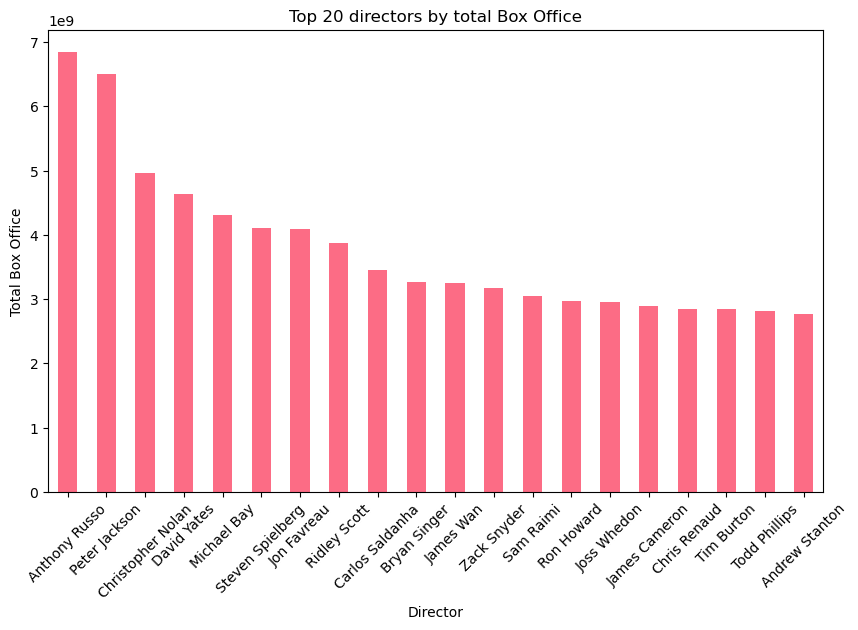

In [24]:
#Parisa
# Aggregate total_box_office per director
director_box_office = merged_data.groupby('director')['total_box_office'].sum().sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
director_box_office.plot(kind='bar', color= '#FC6C85')
plt.title('Top 20 directors by total Box Office')
plt.xlabel('Director')
plt.ylabel('Total Box Office')
plt.xticks(rotation=45)
plt.show()

### Conclusion: 
#### This bar plot visualizes the top 20 directors ranked by their total box office revenue. The x-axis represents the directors, and the y-axis shows the total box office revenue in billions. The chart highlights the dominance of directors like Anthony Russo, Peter Jackson, and Christopher Nolan in the film industry.


### Analyze the relationship between rating and the target column, 'total_box_office'

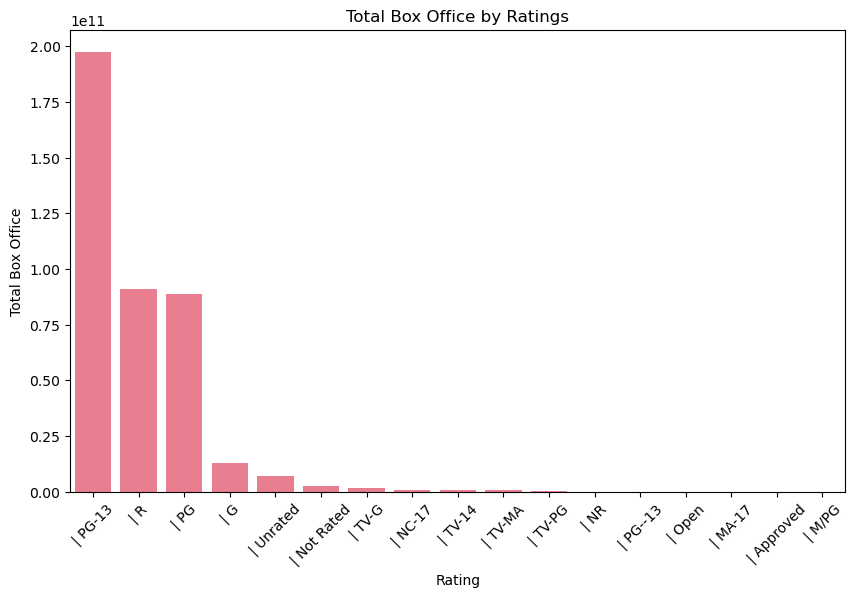

In [25]:
#parisa
# Group by 'rating' and sum the 'total_box_office'
rating_box_office = merged_data.groupby('rating')['total_box_office'].sum().sort_values(ascending=False)

# Plot the total box office by rating
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_box_office.index, y=rating_box_office.values, color='#FC6C85')
plt.title("Total Box Office by Ratings")
plt.xlabel("Rating")
plt.ylabel("Total Box Office")
plt.xticks(rotation=45)
plt.show()

### Conclusion: 
#### This bar plot illustrates the total box office revenue segmented by movie ratings. The x-axis represents the ratings (e.g., PG-13, R, PG), and the y-axis indicates the total box office revenue in billions. It is obvious that PG-13 and R-rated movies dominate in terms of revenue generation compared to other ratings.


### Analyze the relationship between runtime and the target column, 'total_box_office'

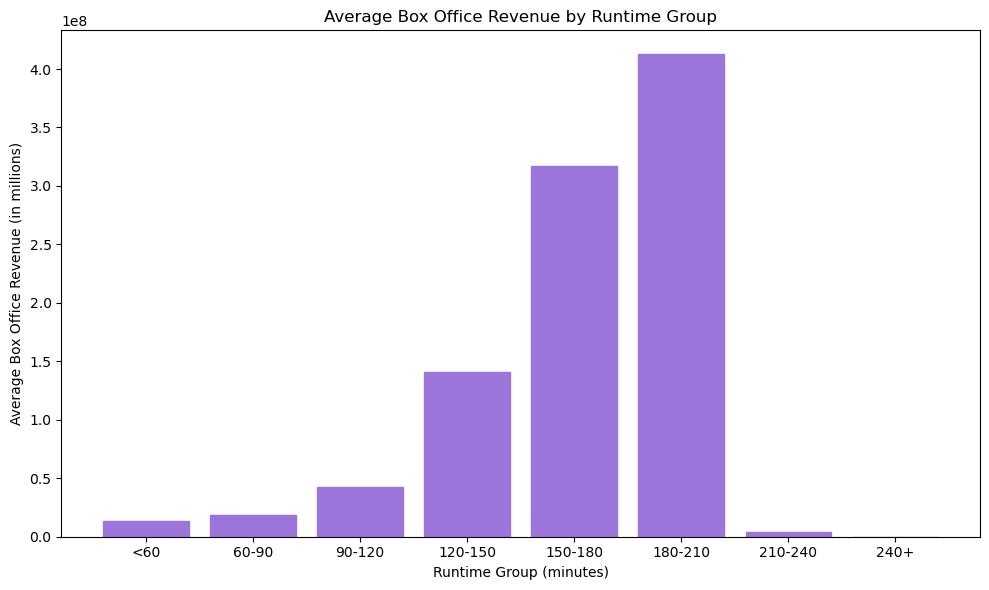

In [26]:
# Ghazaleh
# Define runtime bins
bins = [0, 60, 90, 120, 150, 180, 210, 240, 300] 
labels = ['<60', '60-90', '90-120', '120-150', '150-180', '180-210', '210-240', '240+']

# Add a new column 'runtime_group' to the dataframe
merged_data['runtime_group'] = pd.cut(merged_data['runtime'], bins=bins, labels=labels, right=False)

# Group by 'runtime_group' and calculate mean box office revenue
grouped_data = merged_data.groupby('runtime_group')['total_box_office'].mean().reset_index()

# Plot the average box office revenue for each runtime group
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['runtime_group'], grouped_data['total_box_office'], color='#9B75D9', edgecolor='#9B75D9')
plt.title('Average Box Office Revenue by Runtime Group')
plt.xlabel('Runtime Group (minutes)')
plt.ylabel('Average Box Office Revenue (in millions)')
plt.tight_layout()
plt.show()


### Conclusion:
#### Movies with runtimes between 150-210 minutes generate the highest average box office revenue, while shorter and very long runtimes have lower returns.


In [27]:
# drop runtime_group becuase it was used just for the visualization 
merged_data = merged_data.drop(columns='runtime_group', errors='ignore')


### Analyze the relationship between studio and the target column, 'total_box_office'

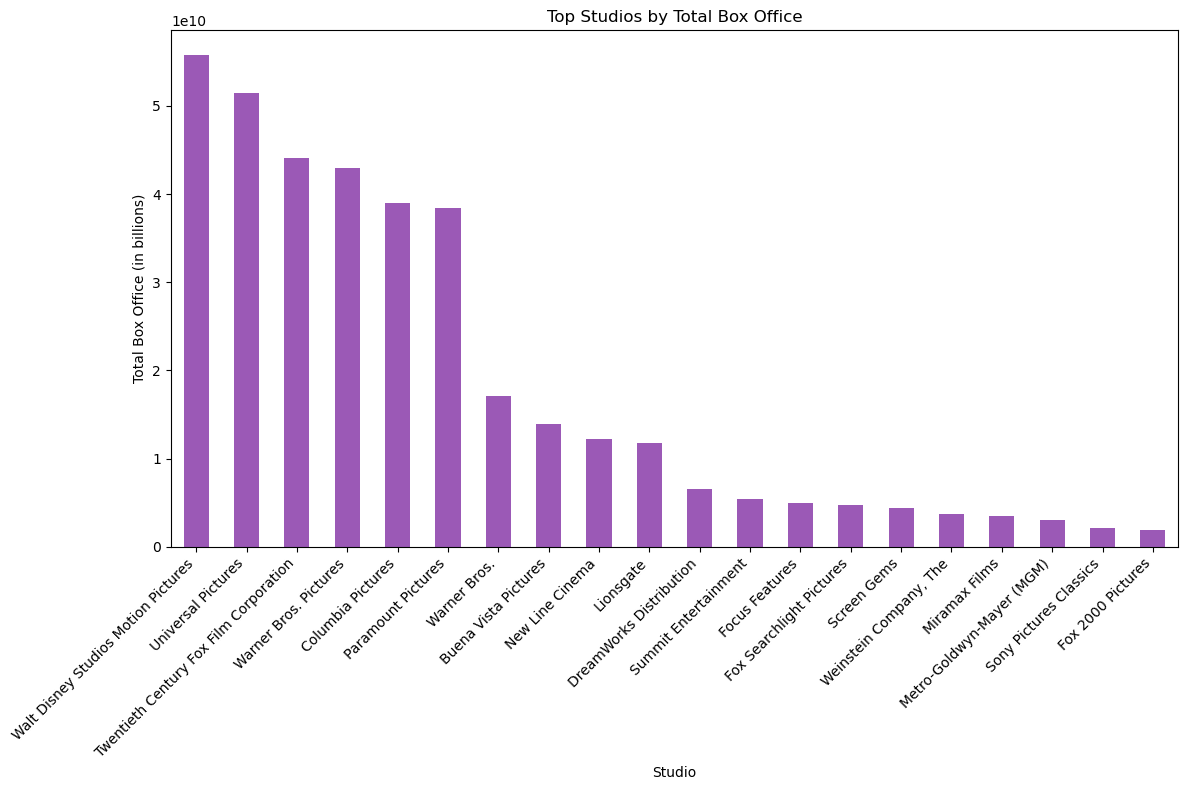

In [28]:
# Ghazaleh
# Group the data by studio and sum the total box office
studio_box_office = merged_data.groupby('studio')['total_box_office'].sum().sort_values(ascending=False).head(20)

# Plot the top studios by total box office
plt.figure(figsize=(12, 8))
studio_box_office.plot(kind='bar', color='#9B59B6')
plt.title('Top Studios by Total Box Office')
plt.xlabel('Studio')
plt.ylabel('Total Box Office (in billions)')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()



### Conclusion: 
#### The top studios, such as Studios Motion Pictures, Universal Pictures, and Twentieth Century Fox, dominate total box office revenue, while smaller studios contribute significantly less, indicating a concentration of success among major players in the industry.

### Average total box office with creative type

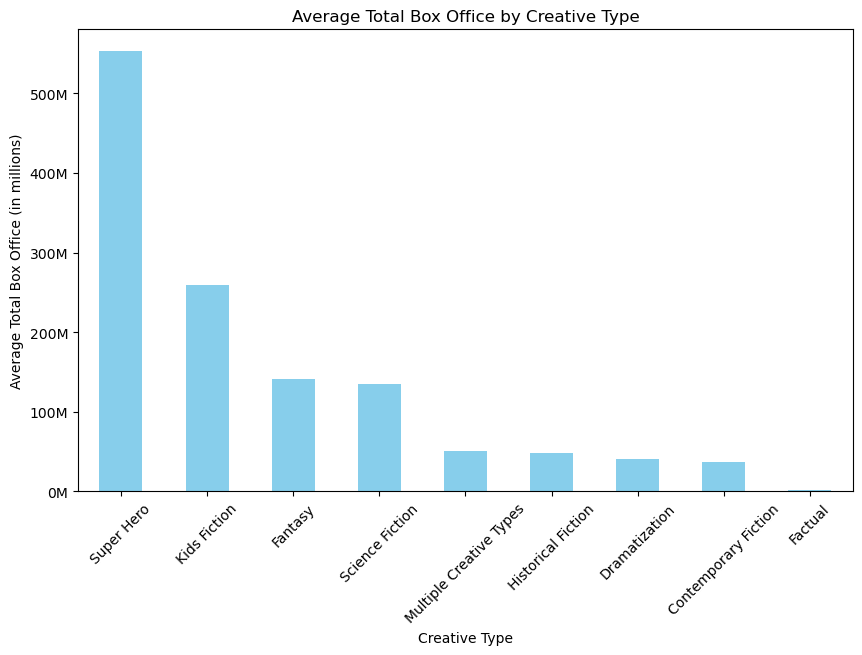

In [29]:
# Julian
plt.figure(figsize=(10, 6))
mean_box_office = merged_data.groupby('creative_type')['total_box_office'].mean().sort_values(ascending=False)
mean_box_office.plot(kind='bar', color='skyblue')

plt.title("Average Total Box Office by Creative Type")
plt.xlabel("Creative Type")
plt.ylabel("Average Total Box Office (in millions)")

# Format y-axis to show numbers in millions
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))

plt.xticks(rotation=45)
plt.show()


### Conclusion: 
#### Super Hero category clearly dominates in terms of average box office, while other categories barely contribute to high revenues. This highlights the commercial potential of certain genres


### <span style="color:pink">3.8 Visualizing the columns distribution</span>


### Distributions of Ratings and Runtime


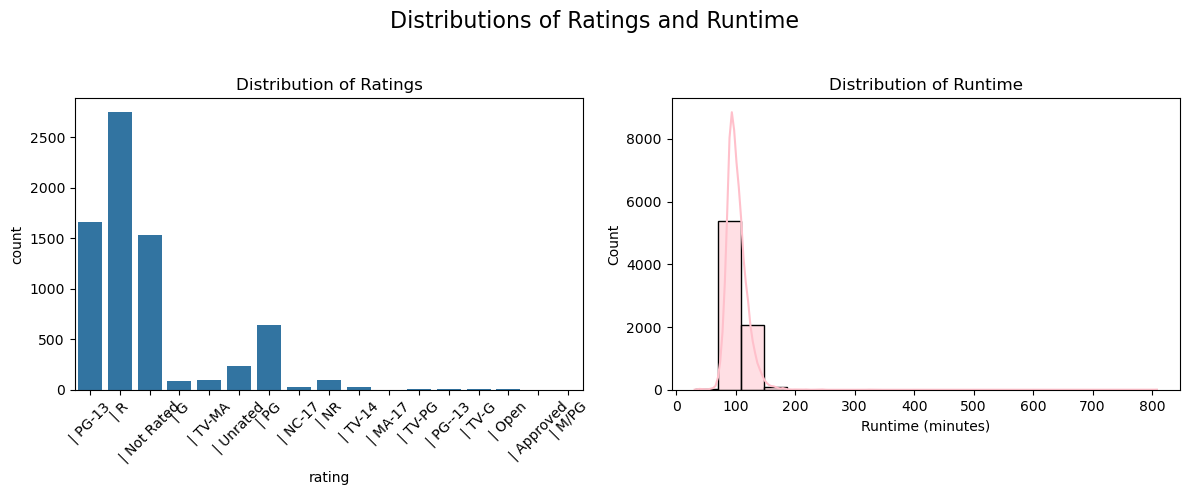

In [30]:
#Parisa
# Set up a grid of plots for distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Distributions of Ratings and Runtime", fontsize=16)

# Plot 1 --> Distribution of 'rating'
sns.countplot(x='rating', data=merged_data, ax=axes[0], hue=None)
axes[0].set_title("Distribution of Ratings")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2 --> Distribution of 'runtime'
sns.histplot(merged_data['runtime'], bins=20, kde=True, color="pink", ax=axes[1])
axes[1].set_title("Distribution of Runtime")
axes[1].set_xlabel("Runtime (minutes)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Conclusion
From the visualizations:
- **Distribution of Ratings**:
   - The majority of movies fall under categories such as **PG-13**, **R**, and **Not Rated**.
   - Other ratings appear far less frequently.

- **Distribution of Runtime**:
   - Most movies have a runtime between **80 and 120 minutes**, as indicated by the sharp peak.
   - Very few movies exceed 200 minutes.

   ### =============================================================================

### Visualize the top 10 actors
#### cast is a string with multiple names, so we may need to split it or extract insights but I do it on temporarily datafram

/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_8956/3387007080.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_actors.values, y=top_actors.index, palette='muted')


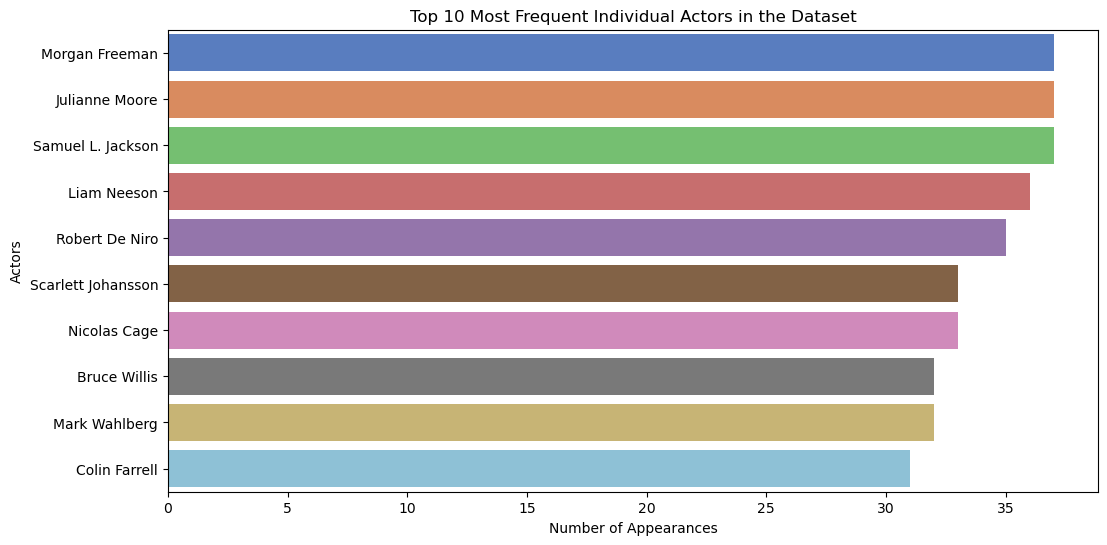

In [31]:
#parisa
# Split 'cast' column and create a list of all actors
all_actors = merged_data['cast'].dropna().str.split(',').sum()

# Remove leading/trailing whitespaces and filter out 'Unknown'
all_actors = [actor.strip() for actor in all_actors if actor.strip() != 'Unknown']

# Count frequency of each actor's appearance
actor_counts = pd.Series(all_actors).value_counts()

# Get the Top 10 most frequent actors
top_actors = actor_counts.head(10)

# Plot the Top 10 actors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_actors.values, y=top_actors.index, palette='muted')
plt.title("Top 10 Most Frequent Individual Actors in the Dataset")
plt.xlabel("Number of Appearances")
plt.ylabel("Actors")
plt.show()


### Conclusion: 
- The chart displays the Top 10 most frequent individual actors in the dataset by counting the number of appearances across all rows. The cast column was split into individual actors, cleaned, and filtered to exclude any 'Unknown' values.

- Julianne Moore has the highest number of appearances in the dataset, followed by Robert De Niro and Dwayne Johnson.
These frequent actors may play a significant role in influencing the target variable (total_box_office).

=============================================================================

### Top 10 Most Common Directors
This bar chart displays the **Top 10 most frequent directors** in the dataset, ranked by the number of movies they directed. The horizontal bar chart enhances readability, especially with longer director names.


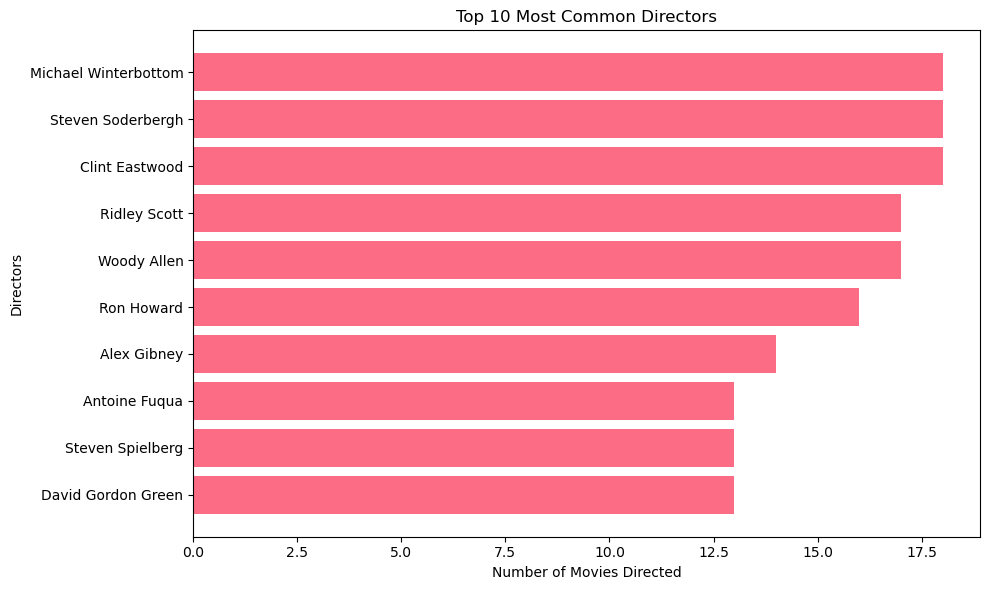

In [32]:
#Parisa
# Top 10 Most Common Directors
top_directors = merged_data['director'].value_counts().head(10)

# Plot Top 10 Directors
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors.values, color= '#FC6C85')
plt.title("Top 10 Most Common Directors")
plt.xlabel("Number of Movies Directed")
plt.ylabel("Directors")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


### Conclusion
From the visualization:
- **Clint Eastwood**, **Ridley Scott**, and **Woody Allen** are the top three directors, each contributing a significant number of movies.
- Other notable directors like **Steven Spielberg** and **Ron Howard** also appear frequently.
### =============================================================================

## Visualize Total Box Office Revenue between 2000 and 2022

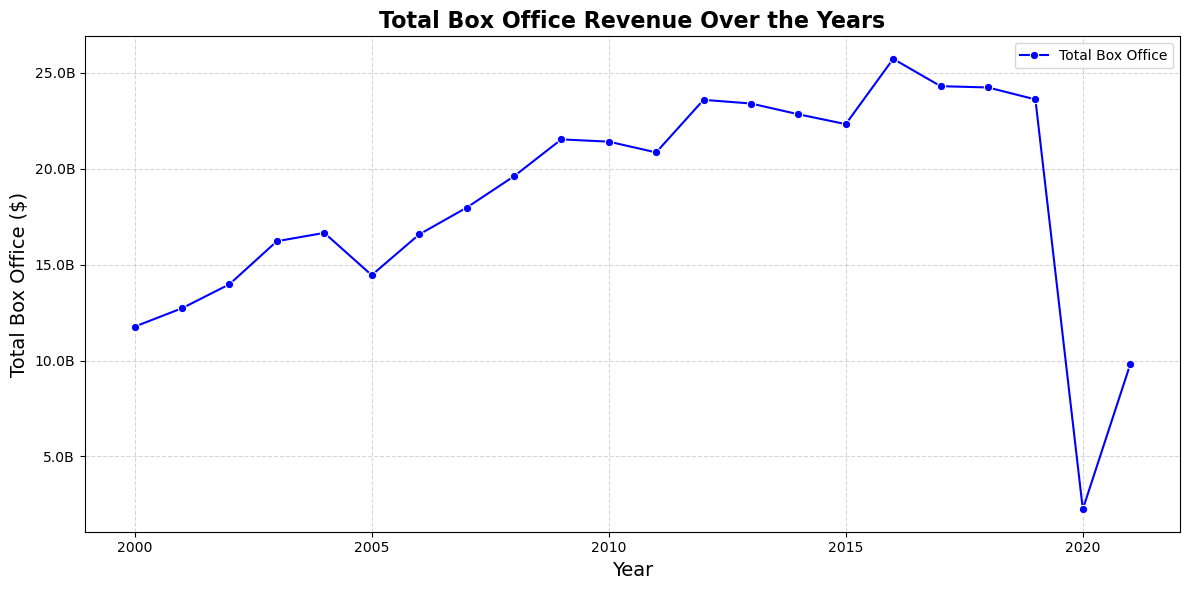

In [33]:
#Arezoo 
# Ensure the dataset contains "year" and "total_box_office"
if "year" in merged_data.columns and "total_box_office" in merged_data.columns:
    # Group data by year to find the mean or sum of box office revenue per year
    yearly_data = merged_data.groupby("year")["total_box_office"].sum().reset_index()

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_data, x="year", y="total_box_office", marker="o", color="blue", label="Total Box Office")
    
    # Customize the plot
    plt.title("Total Box Office Revenue Over the Years", fontsize=16, fontweight="bold")
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Total Box Office ($)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Format y-axis to show values in "millions" or "billions"
    def millions_billions_formatter(x, _):
        if x >= 1e9:
            return f'{x / 1e9:.1f}B'
        elif x >= 1e6:
            return f'{x / 1e6:.1f}M'
        else:
            return f'{x:.0f}'

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(millions_billions_formatter))
    
    # Show the plot
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("The dataset must contain 'year' and 'total_box_office' columns.")


### Conclusion:
  1.⁠ ⁠Long-term growth in the box office industry:
- From the early 2000s through the mid-2010s, total box office revenue showed an overall upward trend, reflecting the industry’s expansion. Factors contributing to this growth include wider global audiences, technological innovations (e.g., IMAX, 3D), and blockbuster franchises.
- ⁠The sharp decline in 2020 clearly reflects the COVID-19 pandemic's impact, as theaters closed and moviegoers shifted to streaming platforms.
2.⁠ ⁠Future Business Adaptations:
- The 2020 drop highlights the necessity of diversifying distribution methods, such as streaming releases and hybrid models, to moderate risks from future disruptions.
- ⁠Post-pandemic recovery could present opportunities for growth, especially as theaters reopen and new strategies emerge.
3.⁠ ⁠Data Insights for Prediction Models:
- Year serves as a critical variable for modeling box office revenue.

=============================================================================

### Comparison of Total and Mean Box Office Revenue by Genre

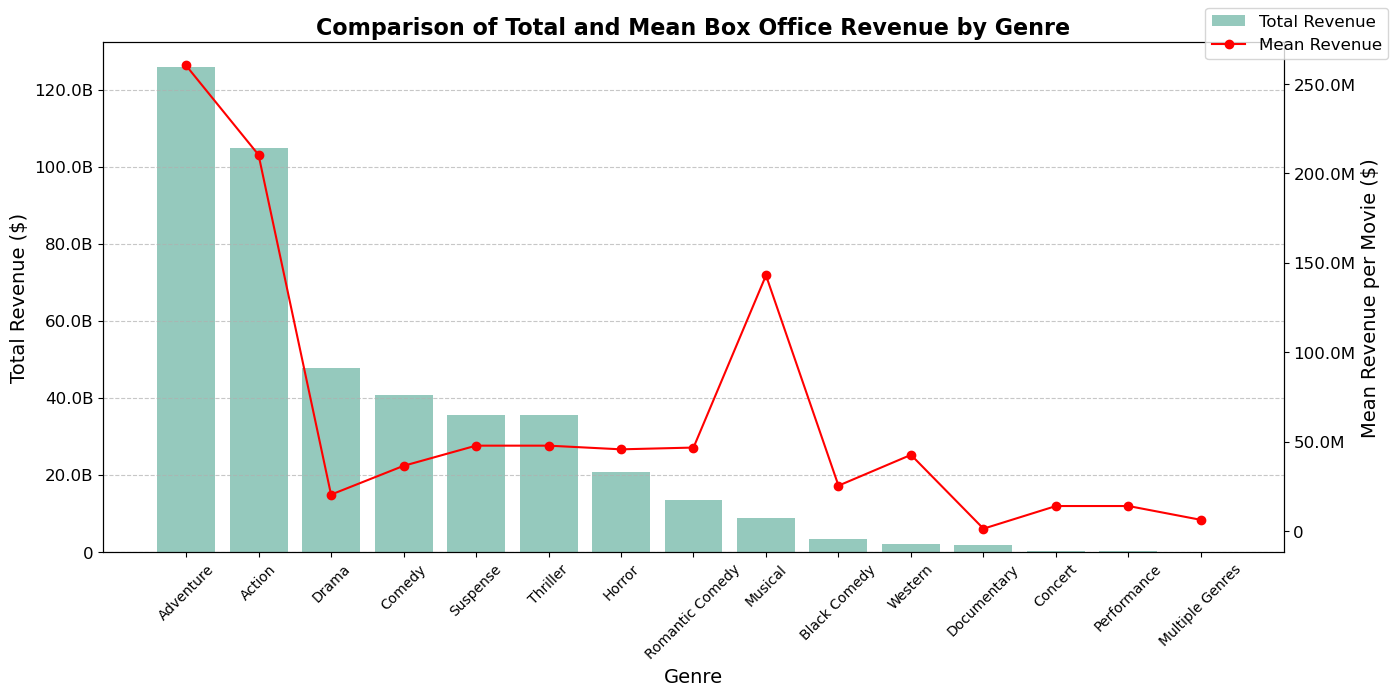

In [34]:
# Arezoo
# Split genres and flatten the list
all_genres = merged_data['genre'].str.split('/').explode().str.strip().reset_index()

# Merge flattened genres with box office column
genre_box_office = merged_data[['total_box_office']].copy()
genre_box_office = genre_box_office.merge(all_genres, left_index=True, right_on='index')

#  Calculate total and mean box office revenue by genre
total_revenue_per_genre = genre_box_office.groupby('genre')['total_box_office'].sum()
mean_revenue_per_genre = genre_box_office.groupby('genre')['total_box_office'].mean()

#  Combine into one DataFrame for plotting
revenue_data = pd.DataFrame({
    'Total Revenue': total_revenue_per_genre,
    'Mean Revenue': mean_revenue_per_genre
}).sort_values('Total Revenue', ascending=False)

#  Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot total revenue on the primary y-axis
ax1.bar(revenue_data.index, revenue_data['Total Revenue'], color="#69b3a2", alpha=0.7, label='Total Revenue')
ax1.set_ylabel('Total Revenue ($)', fontsize=14)
ax1.set_xlabel('Genre', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis for total revenue
def format_total_revenue(x, _):
    if x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    else:
        return f'{x:.0f}'
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_total_revenue))

# Plot mean revenue on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(revenue_data.index, revenue_data['Mean Revenue'], color='red', marker='o', label='Mean Revenue')
ax2.set_ylabel('Mean Revenue per Movie ($)', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# Format y-axis for mean revenue
def format_mean_revenue(x, _):
    if x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    else:
        return f'{x:.0f}'
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_mean_revenue))

# Add a title and legend
plt.title('Comparison of Total and Mean Box Office Revenue by Genre', fontsize=16, fontweight='bold')
fig.legend(loc='upper right', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Conclusion: 
- ⁠Adventure movies produce the highest total box office among all the genres(over $120B) and we can see that the average box office "per movie" in this genre is highest(approximately $250M) in comparison to other genres.
- ⁠The next profitable genre is Action with total box office and average box office per movie of $100B and $220M respectively.
- ⁠The next categories are Comedy, Drama, Suspense, and Thriller which their total box office are between $30B and $50B and their average box office per movie in these categories are less than 100M.
- The most interesting genre is Musical whith total box office of less than $10B. while the average box office for movies in this genre is over 150M which is higher than movies in the Comedy, Drama, etc.
#### Recomendation:
- ⁠Invest in Adventure and Action for large-scale projects 
- ⁠Explore niche genres like Musical or Black Comedy for high average profitability with potentially lower production budgets.

=============================================================================

### Univariate Analysis Creative_type


/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_8956/517109669.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


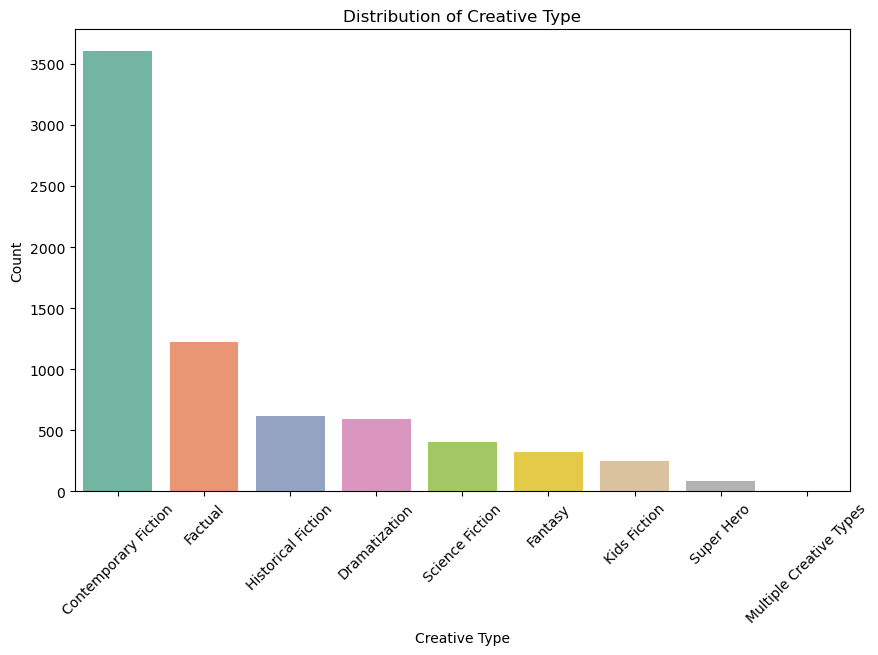

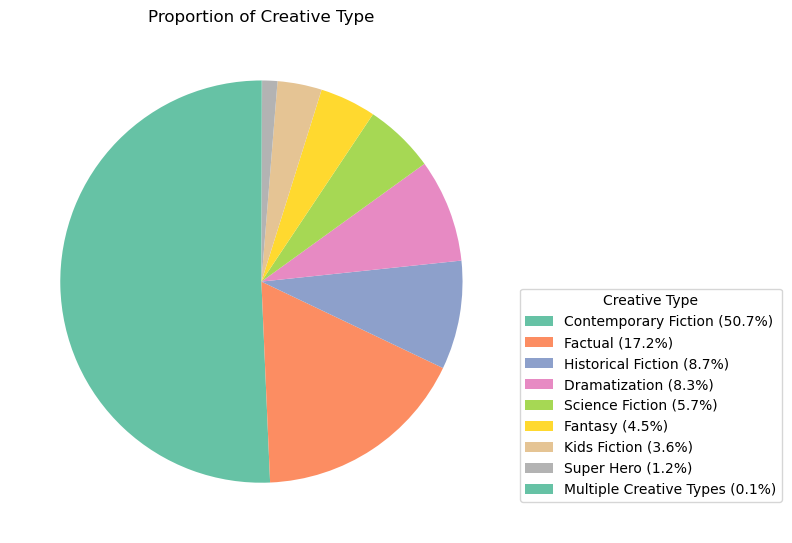

In [35]:
# Julian
# Plot 1: Bar chart for 'creative_type'
plt.figure(figsize=(10, 6))
sns.countplot(
    x='creative_type', 
    data=merged_data, 
    palette='Set2', 
    order=merged_data['creative_type'].value_counts().index
)
plt.title("Distribution of Creative Type")
plt.xlabel("Creative Type")
plt.ylabel("Count")
plt.xticks(rotation=45)  
plt.show()

# Plot 2: Pie chart for 'creative_type' with custom colors and percentages in the legend
plt.figure(figsize=(8, 8))

custom_colors = sns.color_palette('Set2', n_colors=len(merged_data['creative_type'].unique()))

# pie chart 
wedges, texts = plt.pie(
    merged_data['creative_type'].value_counts(), 
    startangle=90, 
    colors=custom_colors,
    labels=None  
)

# Add percentages
plt.legend(
    wedges,
    [f"{label} ({percentage:.1f}%)" for label, percentage in zip(
        merged_data['creative_type'].value_counts().index,
        100 * merged_data['creative_type'].value_counts(normalize=True)
    )],
    title="Creative Type",
    loc="best",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Proportion of Creative Type")
plt.tight_layout()
plt.show()



### Conclusion: 
- The dataset is heavily skewed towards Contemporary Fiction, indicating a clear imbalance in the distribution of creative types. Other categories contribute significantly less to the dataset.

=============================================================================

### Univariate Analysis Production_budget


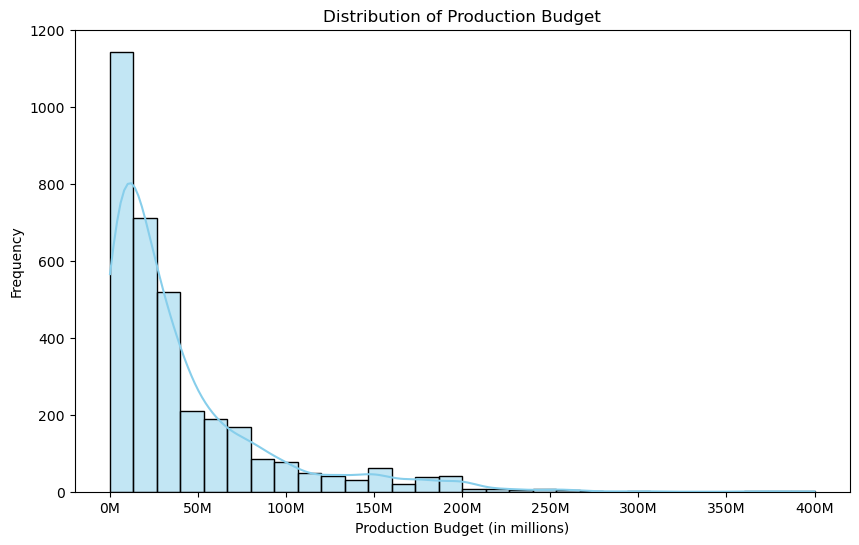

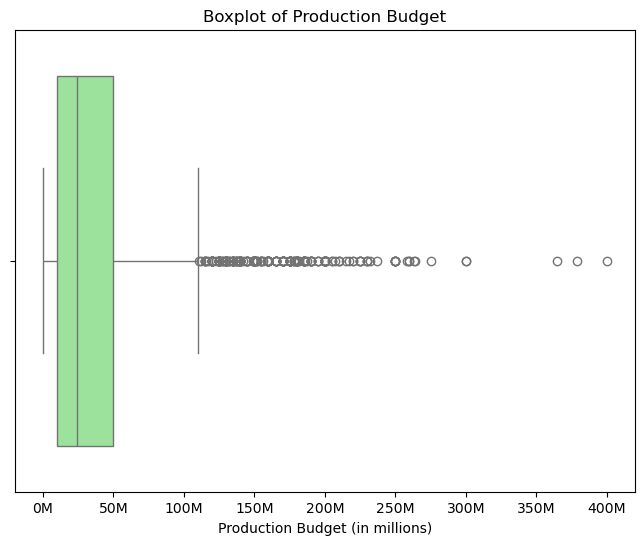

In [36]:
# Julian
# Plot 1: Histogram for 'production_budget' with formatted x-axis
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['production_budget'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Production Budget")
plt.xlabel("Production Budget (in millions)")
plt.ylabel("Frequency")

# Format x-axis to display in millions
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))
plt.show()

# Plot 2: Boxplot for 'production_budget' with formatted x-axis
plt.figure(figsize=(8, 6))
sns.boxplot(x='production_budget', data=merged_data, color='lightgreen')
plt.title("Boxplot of Production Budget")
plt.xlabel("Production Budget (in millions)")

# Format x-axis to display in millions
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.0f}M'))
plt.show()

### Conclusion: 
- The majority of movies have low to moderate budgets, while a small fraction of films have extremely high budgets, leading to a left skewed distribution.

=============================================================================

### Bivariate Analysis Creative_type

/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_8956/3213446287.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='creative_type', y='total_box_office', data=merged_data, palette='Set3')


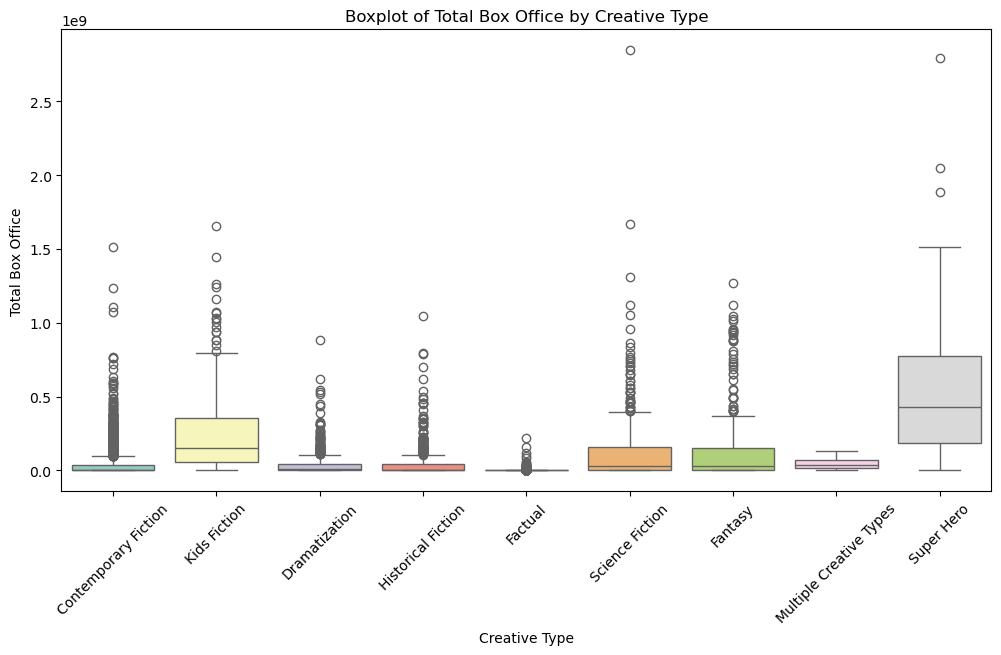

In [37]:
# Julian
plt.figure(figsize=(12, 6))
sns.boxplot(x='creative_type', y='total_box_office', data=merged_data, palette='Set3')
plt.title("Boxplot of Total Box Office by Creative Type")
plt.xlabel("Creative Type")
plt.ylabel("Total Box Office")
plt.xticks(rotation=45)
plt.show()

### Conclusion: 
- Kids Fiction and Super Hero genres dominate with the highest median box office revenues, with Super Hero films showcasing exceptional top outliers near the 2 billion-dollar mark. Science Fiction also has notable outliers, though the overall performance is less consistent. Other creative types significantly underperform compared to Kids Fiction and Super Hero, with much lower box office revenues.

=============================================================================

### Bivariate Analysis -- Scatterplot Production_budget

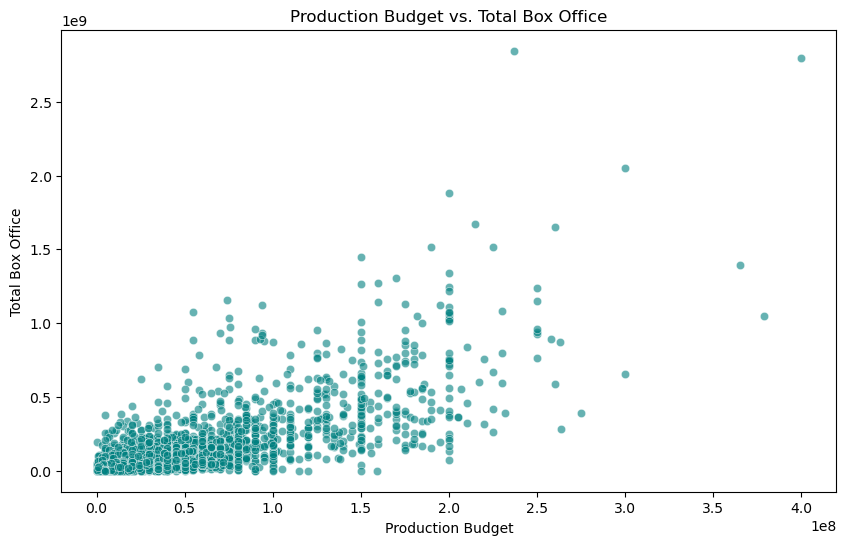

In [38]:
# Julian
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='total_box_office', data=merged_data, color='teal', alpha=0.6)
plt.title("Production Budget vs. Total Box Office")
plt.xlabel("Production Budget")
plt.ylabel("Total Box Office")
plt.show()

### Conclusion:
- Although a higher production budget often leads to a higher total box office, success is not guaranteed. Films with low budgets can still generate reasonable revenues, while high budgets sometimes do not yield the expected success.

---

# <span style="color:pink">4.Feature Engineering</span>

### ⁠Created a Season column by mapping months in RelDate to seasons.  ⁠Converted Season into an ordered categorical type: Spring < Summer < Fall < Winter.  Verified the column output and data type.

In [39]:
# Ghazaleh
# Define a function to map months to seasons
def get_season(date):
    if pd.isna(date): 
        return 'Unknown'
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Unknown'

# Apply the function to extract seasons from 'RelDate'
merged_data['season'] = merged_data['RelDate'].apply(get_season)

# Convert the 'Season' column to a categorical data type with ordered seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
merged_data['season'] = pd.Categorical(merged_data['season'], 
                                      categories=season_order, 
                                      ordered=True)

# Display the first rows to confirm
print(merged_data[['RelDate', 'season']].head())

     RelDate  season
0 2016-03-11  Spring
1 2012-09-14    Fall
2 2013-06-28  Summer
3 2015-05-08  Spring
4 2000-11-22    Fall


#### Creating the "release_timing" feature from release-date column. 

 The release_timing feature is a binary variable that categorizes movies based on their release day as either "Early" (days 1–15, represented as 0) or "Late" (days 16–end of the month, represented as 1). 
 In some cases this binary feature is designed to capture potential patterns in marketing strategies, audience engagement, or revenue trends associated with release timing, but in order to make sure for this dataset this feature is useful or not, we will create it. Then check the correlation with the box office. If the correlation was very small then we remove it, otherwise we keep it.

In [40]:
# Arezoo
# Ensure the RelDate column is in datetime format
merged_data['RelDate'] = pd.to_datetime(merged_data['RelDate'])

# Extract the day from the RelDate column
merged_data['release_day'] = merged_data['RelDate'].dt.day

# Display the updated merged data with the new column
print(merged_data[['RelDate', 'release_day']].head())

#create a binary feature for release timing: 0 for early in the month(1-15th), 
# 1 for Late in the month(16+), and 2 for None(missing dates)
merged_data["release_timing_binary"]= merged_data["release_day"].apply(
    lambda x: 0 if pd.notnull(x) and x<=15 else (1 if pd.notnull(x) else None)
)
# convert release_day to integer
merged_data["release_day"] = merged_data["release_day"].astype(int)
# Convert release_timing_binary to integer
merged_data["release_timing_binary"] = merged_data["release_timing_binary"].fillna(0).astype(int)

print("sample rows with release timing feature")
merged_data[["RelDate", "release_timing_binary"]].head()

     RelDate  release_day
0 2016-03-11           11
1 2012-09-14           14
2 2013-06-28           28
3 2015-05-08            8
4 2000-11-22           22
sample rows with release timing feature


,RelDate,release_timing_binary
0,2016-03-11,0
1,2012-09-14,0
2,2013-06-28,1
3,2015-05-08,0
4,2000-11-22,1


In [41]:
#drop the release_day column because it's not needed anymore
merged_data.drop(columns=["release_day"], inplace=True)

/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_8956/3278013036.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=release_timing_summary, x='release_timing_binary', y='total_box_office', palette='pastel')


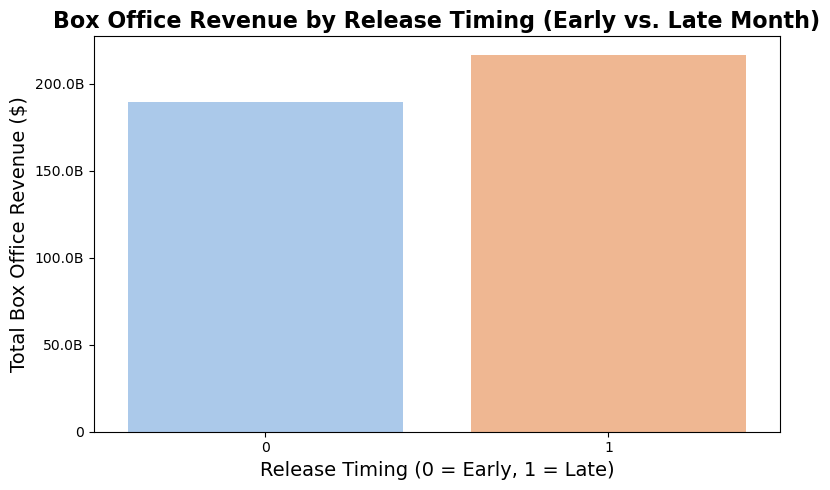

In [42]:
#Arezoo 
# Group data by release_timing_binary and calculate the sum of box office
release_timing_summary = merged_data.groupby('release_timing_binary')['total_box_office'].sum().reset_index()

# Create the plot
plt.figure(figsize=(8, 5))
sns.barplot(data=release_timing_summary, x='release_timing_binary', y='total_box_office', palette='pastel')

# Add labels and title
plt.title("Box Office Revenue by Release Timing (Early vs. Late Month)", fontsize=16, fontweight='bold')
plt.xlabel("Release Timing (0 = Early, 1 = Late)", fontsize=14)
plt.ylabel("Total Box Office Revenue ($)", fontsize=14)

# Format y-axis to show values in millions or billions
def millions_billions_formatter(x, _):
    if x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    else:
        return f'{x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(millions_billions_formatter))

# Show the plot
plt.tight_layout()
plt.show()

### Conclusion: 
#### While movies released later in the month show slightly higher total box office revenue compared to those released earlier, the difference is not statistically significant. This indicates that release timing (early vs. late in the month) has no meaningful impact on box office performance.
=============================================================================

## <span style="color:pink">4.1 Correlation</span>


### First, we'll identify which feature variables are linked to the target variable. Since the features include both continuous and categorical variables, and the target is continuous, we need to use appropriate correlation methods depending on the type of each variable.

## <span style="color:pink">Hypothesis</span>
- **Null Hypothesis (H0):** Column does not significantly influence total_box_office.
- **Alternative Hypothesis (H1):** Column has a significant influence on total_box_office.

### ANOVA Test for 'studio' Against 'total_box_office'

We performed an ANOVA test to check the relationship between the categorical feature studio and the target variable 

- ANOVA tests if the mean total_box_office varies significantly across different studio categories.

In [43]:
# Parisa
# ANOVA test for 'studio' against 'total_box_office'
model_studio = ols('total_box_office ~ C(studio)', data=merged_data).fit()
anova_studio = sm.stats.anova_lm(model_studio, typ=2)
print("ANOVA Results for Studio:")
print(anova_studio)


ANOVA Results for Studio:
                 sum_sq      df        F         PR(>F)
C(studio)  5.324207e+19   807.0  3.82817  1.611117e-200
Residual   1.161755e+20  6741.0      NaN            NaN


### Conclusion:
Since the p-value is extremely small (close to 0), we reject the null hypothesis. This means that the studio variable has a significant impact on the total_box_office.
Therefore, it can be considered as a relevant feature for further analysis.
##### ===============================================

### ANOVA Test for director against total_box_office
### We are performing an ANOVA test to check the relationship between the director (categorical variable) and the total_box_office (continuous target variable).

In [44]:
# Parisa
# ANOVA test for 'director' against 'total_box_office'

# Fit the model
model_director = ols('total_box_office ~ C(director)', data=merged_data).fit()

# Perform ANOVA
anova_director = sm.stats.anova_lm(model_director, typ=2)
 
# Print results
print("ANOVA Results for Director:")
print(anova_director)


ANOVA Results for Director:
                   sum_sq      df         F    PR(>F)
C(director)  1.001590e+20  4455.0  1.045733  0.085362
Residual     7.032376e+19  3271.0       NaN       NaN


### Conclusion:
#### The p-value is below 0.05, indicating that director has a significant impact on the total_box_office. Therefore we reject the null hypothesis, the director column is an important feature for predicting the target variable.
##### ===============================================


### Pearson Correlation Test for Runtime against Total Box Office

### We are performing a Pearson correlation test to evaluate the linear relationship between the runtime (continuous feature) and the total_box_office (target variable). The Pearson correlation coefficient ranges between -1 and 1:


In [45]:
# Parisa
# Filter out rows with NaN or infinite values in either 'runtime' or 'total_box_office'
filtered_data = merged_data[
    merged_data[['runtime', 'total_box_office']].applymap(np.isfinite).all(axis=1)
]

# Calculate Pearson correlation on the filtered data
runtime_corr, p_value = pearsonr(filtered_data['runtime'], filtered_data['total_box_office'])

# Print the results
print(f"Pearson Correlation Coefficient for Runtime vs Total Box Office: {runtime_corr:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Pearson Correlation Coefficient for Runtime vs Total Box Office: 0.2781
P-value: 1.1675e-134
The correlation is statistically significant.


 ### Conclusion:
#### The correlation is statistically significant since the p-value is extremely low. The Pearson correlation coefficient of 0.2781 indicates a weak positive linear relationship between runtime and total box office. This suggests that longer runtimes may have a slight tendency to achieve higher box office earnings.
##### ===============================================

### ANOVA test for 'cast' against 'total_box_office'


We performed an ANOVA test to check the relationship between the categorical feature ⁠ cast ⁠ and the target variable ⁠ total_box_office ⁠.

Threshold for Cast Members:  
   To reduce the number of unique categories, cast members with fewer than 5 appearances are grouped into an "Other" category.

In [46]:
#Ghazale
#Fit the ANOVA model for cast and total_box_office
model_cast = ols('total_box_office ~ C(cast)', data=merged_data).fit()

# Perform ANOVA
anova_cast = sm.stats.anova_lm(model_cast, typ=2)

print("ANOVA Results for Cast:")
print(anova_cast)

#interpretation
alpha = 0.05
p_value = anova_cast['PR(>F)'][0]

if p_value < alpha:
    print(f"\nThe p-value is {p_value:.5f}. The result is statistically significant. \n There is a relationship between cast and total box office.")
else:
    print(f"\nThe p-value is {p_value:.5f}. The result is not statistically significant. \n There is no strong relationship between cast and total box office.")


ANOVA Results for Cast:
                sum_sq      df         F    PR(>F)
C(cast)   1.596960e+20  5498.0  2.360519  0.000248
Residual  5.537252e+17    45.0       NaN       NaN

The p-value is 0.00025. The result is statistically significant. 
 There is a relationship between cast and total box office.


### conclusion 
#### The ANOVA test shows that the mean total box office significantly differs across cast members. The p-value (< 0.05) confirms that these differences are statistically significant. This suggests that cast selection plays a role in box office performance.
##### ===============================================

#### ANOVA Test for 'rating' Against 'total_box_office'

We performed an ANOVA test to determine if there is a statistically significant relationship between the *rating* and the *total box office*.

In [47]:
# Ghazale
# ANOVA test for 'rating' against 'total_box_office'
model_rating = ols('total_box_office ~ rating', data=merged_data).fit()

# Perform ANOVA test on the model
anova_rating = sm.stats.anova_lm(model_rating, typ=2)

# Print ANOVA results
print("ANOVA Results for Rating:")
print(anova_rating)

ANOVA Results for Rating:
                sum_sq      df          F         PR(>F)
rating    1.878478e+19    16.0  56.093288  7.691262e-170
Residual  1.501539e+20  7174.0        NaN            NaN


#### Conclusion
#### The ANOVA test shows a statistically significant relationship between rating and total box office performance (p-value = 0.0). This result indicates that variations in ratings are strongly associated with differences in total box office revenue.
##### ===============================================

#### ANOVA Test for Season Against Total Box Office
We are performing an ANOVA test to examine the relationship between the season (categorical variable) and total_box_office (continuous target variable). This helps determine if box office performance varies significantly across different seasons.

In [48]:
# Ghazaleh
# ANOVA test for 'Season' against 'total_box_office'

# Fit the model
model_season = ols('total_box_office ~ C(season)', data=merged_data).fit()

# Perform ANOVA
anova_season = sm.stats.anova_lm(model_season, typ=2)

# Print results
print("ANOVA Results for Season:")
print(anova_season)

ANOVA Results for Season:
                 sum_sq      df        F    PR(>F)
C(season)  4.713779e+17     3.0  7.14495  0.000087
Residual   1.700359e+20  7732.0      NaN       NaN


#### Conclusion
#### The ANOVA test indicates a significant difference in total box office performance across seasons, as shown by the low p-value (0.0187).
##### ===============================================

### Perform Pearson tes for column "year" vs target column "total box office" to see if there is a relationship between the year with box office.

In [49]:
# Arezoo
#Calculate Pearson Correlation
year_corr, p_value = pearsonr(merged_data["year"], merged_data["total_box_office"])

# Print results
print(f"Pearson Correlation Coefficient for Year vs Total Box Office: {year_corr:.4f}")
print(f"P-value: {p_value:.4e}")

#interpretation and setting the significance level
alpha = 0.05  
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Pearson Correlation Coefficient for Year vs Total Box Office: 0.0101
P-value: 3.7278e-01
The correlation is not statistically significant.


#### Conclusion
#### The p-value is greater than the significance level( p=0.37278>α=0.05). This means the correlation is not statistically significant. Then we reject Null Hypothesis and accept the alternative hypothesis. So, we conclude that changes in the year do not have a consistent impact on the total box office revenue.
##### ===============================================

### Perform Anova test for column "genre" with "box office" (numinal > continuous) to see if the mean of box office varies across different genre categories

In [50]:
#Arezoo
#Fit the ANOVA model for genre and total_box_office
model_genre = ols('total_box_office ~ C(genre)', data=merged_data).fit()

# Perform ANOVA
anova_genre = sm.stats.anova_lm(model_genre, typ=2)

print("ANOVA Results for Genre:")
print(anova_genre)

#interpretation
alpha = 0.05
p_value = anova_genre['PR(>F)'][0]

if p_value < alpha:
    print(f"\nThe p-value is {p_value:.5f}. The result is statistically significant. \n There is a relationship between genre and total box office.")
else:
    print(f"\nThe p-value is {p_value:.5f}. The result is not statistically significant. \n There is no strong relationship between genre and total box office.")

ANOVA Results for Genre:
                sum_sq      df           F  PR(>F)
C(genre)  3.984378e+19    12.0  189.192761     0.0
Residual  1.297289e+20  7392.0         NaN     NaN

The p-value is 0.00000. The result is statistically significant. 
 There is a relationship between genre and total box office.


#### Conclusion
The p-value is significantly less than the significance level (p=0.00000 < α=0.05).
This indicates that the relationship between genre and total box office revenue is statistically significant.
In other words, the genre of a movie has a significant impact on its box office revenue.

F-statistic: 189.192761
A high F-statistic indicates that the variability explained by the genre is much greater than the variability within genres.

Business Implications:
It would be better to focus on high-performing genres when planning new movie projects.

##### ===============================================

#### Perform the ANOVA on the column "release_timing" vs "box office" to see if a movie released early in the month or late in the month has an effect on the box office. I do the ANOVA becasue there are only two categories in this column.

In [51]:
# Split the box office data into two groups based on release_timing
early_release = merged_data[merged_data['release_timing_binary'] == 0]['total_box_office']
late_release = merged_data[merged_data['release_timing_binary'] == 1]['total_box_office']

# Combine the data into a single DataFrame for ANOVA
anova_data = merged_data[['release_timing_binary', 'total_box_office']]

# Perform ANOVA
model = ols('total_box_office ~ C(release_timing_binary)', data=anova_data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Print ANOVA results
print("ANOVA Results for Release Timing vs Box Office Revenue:")
print(anova_results)

# Interpret the results
p_value = anova_results['PR(>F)'][0]  # Extract the p-value
alpha = 0.01
if p_value < alpha:
    print(f"\nThe p-value is {p_value:.5f}. The result is statistically significant: Release timing has a significant effect on box office revenue.")
else:
    print(f"\nThe p-value is {p_value:.5f}. The result is not statistically significant: Release timing does not significantly affect box office revenue.")

ANOVA Results for Release Timing vs Box Office Revenue:
                                sum_sq      df         F    PR(>F)
C(release_timing_binary)  1.052611e+17     1.0  4.777465  0.028864
Residual                  1.704020e+20  7734.0       NaN       NaN

The p-value is 0.02886. The result is not statistically significant: Release timing does not significantly affect box office revenue.


##### ===============================================
### Correlation creative_type, total_box_office

In [52]:
# Julian 
# ANOVA test for 'creative_type' against 'total_box_office'
model_creative_type = ols('total_box_office ~ C(creative_type)', data=merged_data).fit()
anova_creative_type = sm.stats.anova_lm(model_creative_type, typ=2)
print("ANOVA Results for Creative Type:")
print(anova_creative_type)

ANOVA Results for Creative Type:
                        sum_sq      df           F  PR(>F)
C(creative_type)  4.173710e+19     8.0  291.737874     0.0
Residual          1.269154e+20  7097.0         NaN     NaN


### Conclusion: 
#### The very small p-value (close to 0) shows that a movie's creative_type has a significant impact on its total_box_office. The high F-value (291.74) means there are big differences in box office performance between the creative_type categories, showing that some creative types do much better than others.
##### ===============================================


### Correlation keywords, total_box_office

In [53]:
# 2. ANOVA test for 'keywords' against 'total_box_office'
model_keywords = ols('total_box_office ~ C(keywords)', data=merged_data).fit()
anova_keywords = sm.stats.anova_lm(model_keywords, typ=2)
print("ANOVA Results for Keywords:")
print(anova_keywords)


ANOVA Results for Keywords:
                   sum_sq      df         F         PR(>F)
C(keywords)  6.230114e+19   857.0  3.631274  2.684970e-177
Residual     1.007788e+20  5034.0       NaN            NaN


### Conclusion:
 #### The very small p-value (< 0.0001) shows that keywords have a significant impact on total_box_office, meaning they help explain differences in box office performance. The F-statistic of 3.63 indicates that while there are clear differences in revenue between keyword groups, the impact of keywords may not be very strong. This suggests that keywords are important but don’t explain all the variations in box office revenue.
##### ===============================================

#### Pearson Correlation between Production Budget and Total Box Office Revenue
Since both "Production Budget" and "Total Box Office Revenue" are continuous numerical variables, we will calculate the Pearson correlation to measure the strength and direction of their linear relationship.

Pearson Correlation between Production Budget and Total Box Office: 0.751, P-value: 0.000e+00


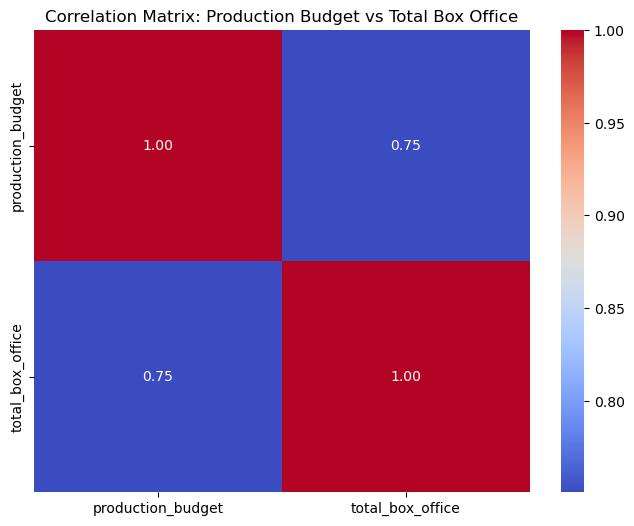

In [54]:
# Julian 
# Filter out rows with NaN or infinite values in 'production_budget' and 'total_box_office'
filtered_data = merged_data[
    merged_data[['production_budget', 'total_box_office']].applymap(np.isfinite).all(axis=1)
]

# Calculate Pearson correlation on the filtered data
correlation, p_value = pearsonr(filtered_data['production_budget'], filtered_data['total_box_office'])

# Print the results
print(f"Pearson Correlation between Production Budget and Total Box Office: {correlation:.3f}, P-value: {p_value:.3e}")

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    filtered_data[['production_budget', 'total_box_office']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Matrix: Production Budget vs Total Box Office")
plt.show()


#### Conclusion
#### There is a strong positive correlation (r = 0.75) between production budget and total box office revenues. This suggests that films with higher production budgets tend to generate higher revenues, making budget a key predictor of success. However, the high correlation may also indicate some redundancy with other related features.


# <span style="color:pink">Attention!</span>
### As we saw when we compare the correlation value of the production budget with box office, when we fill the production budget null values with median we get highet correlation value with the box office rather than when we implement the knn imputer. Consequently, we will continue with the median method. 
##### ===============================================

### save the merged_data to use the data set for transforming.

In [55]:
# All of the team members
# Save the merged data to a new Excel file
output_file_path = '/Users/parisa/Desktop/AI/Final_Assignment/merged_meta_sales.xlsx'
merged_data.to_excel(output_file_path, index=False)

In [56]:
merged_data.columns

Index(['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director',
       'RelDate', 'title_year', 'year', 'genre', 'production_budget',
       'keywords', 'creative_type', 'total_box_office', 'season',
       'release_timing_binary'],
      dtype='object')

In [57]:
# All of the team members
# print the unique number of each category
print('The unique number of each category:')
print('studio:', merged_data["studio"].nunique())
print('rating:', merged_data["rating"].nunique())
print('cast:',merged_data["cast"].nunique())
print('director:', merged_data["director"].nunique())
print('keywords:',merged_data["keywords"].nunique())
print('creative type:', merged_data["creative_type"].nunique())

The unique number of each category:
studio: 808
rating: 17
cast: 5499
director: 4456
keywords: 858
creative type: 9


### Reason: 
### We reduced the number of unique values in features like studio, cast, director, and keywords to make the results easier to understand for stakeholders. 
### Having too many unique values, like thousands of actors or directors, adds complexity to the model and makes it hard to identify clear patterns. By keeping only the top contributors (e.g., the most frequent or impactful ones) and grouping the rest as 'Other,' we can focus on the categories that matter most. This approach makes it easier to explain how specific studios, actors, or directors influence box office revenue, helping stakeholders make better decisions based on clear and actionable insights.

In [58]:
# All of team members
# reduce the number of unique value in each category
categorical_cols_to_limit = [
    "studio",
    "cast",
    "director",
    "genre",
    "keywords",
]

def limit_top_n_categories(df, col, top_n=30, other_label="Other"):
    
    # Find the top 30 categories by frequency
    top_categories = df[col].value_counts().nlargest(top_n).index
    
    # Replace everything else with 'Other'
    df[col] = df[col].where(df[col].isin(top_categories), other_label)
    
    return df

for col in categorical_cols_to_limit:
    merged_data = limit_top_n_categories(merged_data, col=col, top_n=10, other_label="Other")

---
# <span style="color:pink">5.Transformer</span>

## Loading the transformer result of expert review dataset which we uploaded as Transformer.ipynb 

In [59]:
expert_transformer = pd.read_excel('/Users/parisa/Desktop/AI/Final_Assignment/expert_transformer_1.xlsx')

In [60]:
print(expert_transformer.isnull().sum())

pca_0    0
pca_1    0
pca_2    0
pca_3    0
pca_4    0
pca_5    0
pca_6    0
pca_7    0
pca_8    0
pca_9    0
url      0
dtype: int64


### Merge review embedding result with the merged_data 

In [61]:
# # Merge expert_transformer back into merged_data
# # 'how="left"' ensures we keep all rows of merged_data. Movies without pre-release reviews get NaNs.
# final_data = merged_data.merge(expert_transformer, on='url', how='left')

In [62]:
# Preprocess URL columns to ensure consistency
merged_data['url'] = merged_data['url'].str.strip().str.lower()
expert_transformer['url'] = expert_transformer['url'].str.strip().str.lower()

# Perform the merge
final_data = merged_data.merge(expert_transformer, on='url', how='left')

# Fill missing values if required
final_data.fillna(0, inplace=True)

# Debugging outputs
print(f"Rows in merged_data: {len(merged_data)}")
print(f"Rows in expert_transformer: {len(expert_transformer)}")
print(f"Rows in final_data (after merge): {len(final_data)}")


Rows in merged_data: 7736
Rows in expert_transformer: 4115
Rows in final_data (after merge): 7736


In [63]:
print(final_data.isnull().sum())


url                      0
title                    0
studio                   0
rating                   0
runtime                  0
cast                     0
director                 0
RelDate                  0
title_year               0
year                     0
genre                    0
production_budget        0
keywords                 0
creative_type            0
total_box_office         0
season                   0
release_timing_binary    0
pca_0                    0
pca_1                    0
pca_2                    0
pca_3                    0
pca_4                    0
pca_5                    0
pca_6                    0
pca_7                    0
pca_8                    0
pca_9                    0
dtype: int64


In [64]:
final_data

,url,title,studio,rating,runtime,cast,director,RelDate,title_year,year,...,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
0,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,Other,Other,2016-03-11,10 Cloverfield Lane2016,2016,...,-0.316456,0.093970,0.243271,-0.026334,-0.242160,0.098554,0.220553,-0.101992,0.100413,0.265553
1,https://www.metacritic.com/movie/10-years,10 Years,Other,| R,100.0,Other,Other,2012-09-14,10 Years2012,2012,...,0.271335,0.282407,0.101853,-0.177299,0.104157,0.248039,-0.026053,-0.041329,0.458178,0.334793
2,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Other,| Not Rated,91.0,Other,Other,2013-06-28,100 Bloody Acres2013,2013,...,-0.851014,-0.232373,-0.029580,-0.096503,0.107262,-0.257108,-0.443127,-0.098747,0.440290,-0.109246
3,https://www.metacritic.com/movie/1001-grams,1001 Grams,Other,| Not Rated,93.0,Other,Other,2015-05-08,1001 Grams2015,2015,...,0.958757,-0.107041,-0.036577,-0.309297,0.513934,0.489606,-0.066192,-0.240246,-0.135368,-0.575068
4,https://www.metacritic.com/movie/102-dalmatians,102 Dalmatians,Other,| G,100.0,Other,Other,2000-11-22,102 Dalmatians2000,2000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,https://www.metacritic.com/movie/zoolander,Zoolander,Paramount Pictures,| R,89.0,Other,Other,2001-09-28,Zoolander2001,2001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7732,https://www.metacritic.com/movie/zoolander-2,Zoolander 2,Paramount Pictures,| PG-13,102.0,Other,Other,2016-02-12,Zoolander 22016,2016,...,-1.148222,-0.145785,-0.663662,-0.009199,0.075895,0.078799,-0.125591,-0.045465,0.025777,0.052998
7733,https://www.metacritic.com/movie/zoom,Zoom,Columbia Pictures,| PG,83.0,Other,Other,2006-08-11,Zoom2006,2006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7734,https://www.metacritic.com/movie/zoom-2016,Zoom,Other,| Not Rated,96.0,Other,Other,2016-09-02,Zoom2016,2016,...,-0.652103,-0.818520,0.492668,-0.474557,-0.175497,-0.377389,-0.181461,-0.014304,0.266331,-0.310694


In [65]:
final_data.columns

Index(['url', 'title', 'studio', 'rating', 'runtime', 'cast', 'director',
       'RelDate', 'title_year', 'year', 'genre', 'production_budget',
       'keywords', 'creative_type', 'total_box_office', 'season',
       'release_timing_binary', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4',
       'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9'],
      dtype='object')

In [66]:
# All of the team members
#Drop the columns that cannot be used as the pre-release features
columns_to_drop = ["url", "title", "RelDate", "title_year"]
final_data = final_data.drop(columns=[col for col in columns_to_drop if col in final_data.columns], errors='ignore')
print(final_data.columns)

Index(['studio', 'rating', 'runtime', 'cast', 'director', 'year', 'genre',
       'production_budget', 'keywords', 'creative_type', 'total_box_office',
       'season', 'release_timing_binary', 'pca_0', 'pca_1', 'pca_2', 'pca_3',
       'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9'],
      dtype='object')


---

# <span style="color:pink">6.Splitting the dataset/ One-Hot encoding</span>

In [67]:
# All of the team members
# Replace null values in specific categorical columns with 'Unknown'
columns_to_fill = ['genre', 'cast', 'studio', 'rating', 'director', 'creative_type' ,'release_timing_binary', 'keywords']

for col in columns_to_fill:
    final_data.loc[:, col] = final_data[col].fillna('Unknown')
    print(f"Missing values in '{col}' filled with 'Unknown'.")

# Verify that missing values are filled
print("\nNull Values After Filling:")
print(final_data[columns_to_fill].isnull().sum())

Missing values in 'genre' filled with 'Unknown'.
Missing values in 'cast' filled with 'Unknown'.
Missing values in 'studio' filled with 'Unknown'.
Missing values in 'rating' filled with 'Unknown'.
Missing values in 'director' filled with 'Unknown'.
Missing values in 'creative_type' filled with 'Unknown'.
Missing values in 'release_timing_binary' filled with 'Unknown'.
Missing values in 'keywords' filled with 'Unknown'.

Null Values After Filling:
genre                    0
cast                     0
studio                   0
rating                   0
director                 0
creative_type            0
release_timing_binary    0
keywords                 0
dtype: int64


In [68]:
# All of the team members

categorical_columns= ['genre', 'cast', 'studio', 'rating', 'director', 'creative_type', 'keywords','season']

X = final_data.drop(columns=["total_box_office"])
y = final_data["total_box_office"]

# Train-Test split before One-Hot encoding
X_train_full, X_test_encoded, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_encoded, X_val_encoded, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Perform one-hot encoding after splitting
X_train = pd.get_dummies(X_train_encoded, columns=categorical_columns)
X_val = pd.get_dummies(X_val_encoded, columns=categorical_columns)
X_test = pd.get_dummies(X_test_encoded, columns=categorical_columns)

# Ensure columns in train and test match
X_train, X_val = X_train.align(X_val, join="left", axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Get the column names
column_names = X_train.columns.tolist()
print("Column names in X_train_encoded:")
print(column_names)

Column names in X_train_encoded:
['runtime', 'year', 'production_budget', 'release_timing_binary', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'genre_Action', 'genre_Adventure', 'genre_Black Comedy', 'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Musical', 'genre_Other', 'genre_Romantic Comedy', 'genre_Thriller/Suspense', 'cast_Cameron Diaz,Eddie Murphy,Mike Myers', 'cast_Daniel Radcliffe,Emma Watson,Rupert Grint', 'cast_Denis Leary,John Leguizamo', 'cast_Eddie Murphy', 'cast_Liam Neeson', 'cast_Natalie Portman', 'cast_Other', 'cast_Sandra Bullock', 'cast_Scarlett Johansson', 'studio_Columbia Pictures', 'studio_Fox Searchlight Pictures', 'studio_IFC Films', 'studio_Lionsgate', 'studio_Magnolia Pictures', 'studio_Other', 'studio_Paramount Pictures', 'studio_Sony Pictures Classics', 'studio_Twentieth Century Fox Film Corporation', 'studio_Universal Pictures', 'studio_Warner Bros. Pictures', 'rating_0', 'rating_| Ap

In [69]:
# All of the team members

# To convert true/false into 0/1 because we use get dummies and it doesnt implement explicitly 
# List of columns to exclude from conversion
continuous_columns = ['runtime', 'year', 'production_budget', 'release_timing_binary', 
                      'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 
                      'pca_6', 'pca_7', 'pca_8', 'pca_9']

# Apply astype(int) selectively to all columns except the specified continuous columns
X_train = X_train.astype({col: 'int' for col in X_train.columns if col not in continuous_columns})
X_val = X_val.astype({col: 'int' for col in X_val.columns if col not in continuous_columns})
X_test = X_test.astype({col: 'int' for col in X_test.columns if col not in continuous_columns})

In [70]:
X_train

,runtime,year,production_budget,release_timing_binary,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,...,keywords_Early / Simultaneous Video-on-Demand release,keywords_Foreign Language,keywords_LGBTQ+,keywords_Musicians,keywords_Other,keywords_Romance,season_Spring,season_Summer,season_Fall,season_Winter
4551,82.0,2016,0.0,0,-0.189672,0.108101,0.010835,-0.440015,0.289241,-0.085146,...,0,0,0,0,1,0,0,1,0,0
1418,122.0,2007,6400000.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
2481,82.0,2010,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,1,0
6603,92.0,2009,0.0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,1,0
2547,77.0,2013,0.0,0,0.807440,0.268142,-0.029061,0.016772,0.264780,0.216696,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,87.0,2008,62000000.0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,1,0,0
3177,117.0,2010,28000000.0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,1,0,0,0
770,94.0,2017,0.0,1,0.248454,0.577235,0.908837,0.137580,-0.271742,0.460295,...,0,0,0,0,0,1,1,0,0,0
5301,99.0,2012,33000000.0,1,-0.599554,-0.205413,-0.057748,-0.636566,-0.405573,0.227432,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# All of the team members

# Define the list of known continuous features
continuous_features = ['year', 'runtime', 'production_budget'] + [f'pca_{i}' for i in range(10)]  # pca_0 to pca_9

# Separate continuous and one-hot encoded columns
continuous_columns = [col for col in column_names if col in continuous_features]
categorical_columns = [col for col in column_names if col not in continuous_features]

# Print the results
print("Continuous Columns:", continuous_columns)
print("Categorical Columns:", categorical_columns)

Continuous Columns: ['runtime', 'year', 'production_budget', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']
Categorical Columns: ['release_timing_binary', 'genre_Action', 'genre_Adventure', 'genre_Black Comedy', 'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Musical', 'genre_Other', 'genre_Romantic Comedy', 'genre_Thriller/Suspense', 'cast_Cameron Diaz,Eddie Murphy,Mike Myers', 'cast_Daniel Radcliffe,Emma Watson,Rupert Grint', 'cast_Denis Leary,John Leguizamo', 'cast_Eddie Murphy', 'cast_Liam Neeson', 'cast_Natalie Portman', 'cast_Other', 'cast_Sandra Bullock', 'cast_Scarlett Johansson', 'studio_Columbia Pictures', 'studio_Fox Searchlight Pictures', 'studio_IFC Films', 'studio_Lionsgate', 'studio_Magnolia Pictures', 'studio_Other', 'studio_Paramount Pictures', 'studio_Sony Pictures Classics', 'studio_Twentieth Century Fox Film Corporation', 'studio_Universal Pictures', 'studio_Warner Bros. Pictures', 'rating_0', 'ra

In [72]:
# All of the team members

# Handle missing values using median imputation
# Compute median from training set only
median_production_budget = X_train['production_budget'].median()
median_runtime = X_train['runtime'].median()

# Fill missing values in 'production_budget' and 'runtime' columns
X_train['production_budget'] = X_train['production_budget'].fillna(median_production_budget)
X_train['runtime'] = X_train['runtime'].fillna(median_runtime)

# Fill missing values in 'production_budget' and 'runtime' columns for the test set
X_test['production_budget'] = X_test['production_budget'].fillna(median_production_budget)
X_test['runtime'] = X_test['runtime'].fillna(median_runtime)

# Fill missing values in 'production_budget' and 'runtime' columns for the validation set
X_val['production_budget'] = X_val['production_budget'].fillna(median_production_budget)
X_val['runtime'] = X_val['runtime'].fillna(median_runtime)

---


In [73]:
print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(X_test.isnull().sum())


runtime                  0
year                     0
production_budget        0
release_timing_binary    0
pca_0                    0
                        ..
keywords_Romance         0
season_Spring            0
season_Summer            0
season_Fall              0
season_Winter            0
Length: 99, dtype: int64
runtime                  0
year                     0
production_budget        0
release_timing_binary    0
pca_0                    0
                        ..
keywords_Romance         0
season_Spring            0
season_Summer            0
season_Fall              0
season_Winter            0
Length: 99, dtype: int64
runtime                  0
year                     0
production_budget        0
release_timing_binary    0
pca_0                    0
                        ..
keywords_Romance         0
season_Spring            0
season_Summer            0
season_Fall              0
season_Winter            0
Length: 99, dtype: int64


# <span style="color:pink">6.Feature Selection</span>

## <span style="color:pink">SVD</span>

In [74]:
# All of team members

# Select the Best k for SVD

k_values = [5, 10, 20, 30, 50]
best_k = None
best_r2_val = -np.inf

for k in k_values:
    svd_temp = TruncatedSVD(n_components=k, random_state=42)
    X_train_reduced_temp = svd_temp.fit_transform(X_train)
    X_val_reduced_temp = svd_temp.transform(X_val)
    
    # Train a simple linear regression to evaluate performance
    lr_temp = LinearRegression()
    lr_temp.fit(X_train_reduced_temp, y_train)
    y_val_pred_scaled_temp = lr_temp.predict(X_val_reduced_temp)
    r2_val_temp = r2_score(y_val, y_val_pred_scaled_temp)
    
    if r2_val_temp > best_r2_val:
        best_r2_val = r2_val_temp
        best_k = k

print(f"Best k for SVD based on validation R²: k={best_k}, R²_val={best_r2_val:.4f}")

# Apply the chosen best_k SVD permanently
svd = TruncatedSVD(n_components=best_k, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_val_reduced = svd.transform(X_val)
X_test_reduced = svd.transform(X_test)

Best k for SVD based on validation R²: k=50, R²_val=0.6993


In [75]:
svd.components_.shape

(50, 99)

In [76]:
svd.singular_values_.shape

(50,)

# <span style="color:pink">8.Modeling</span>

#### We got help from riccardo's github and chatGpt for generating the models
### All of the team members have participated in preparing the models and also explainablity part

### <span style="color:pink">8.1 Linear regression</span>

## Model training: Train two Linear regression Model:
- Using all the variables
- Using Ridge-regularization method

In [77]:
#Train linear regression models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

print('Models are fitted using all the features') 
print("----------------------------------------")

# train the model on the both train and validation datasets since in the linear regression we don't have hyperparameter tuning
X_train_val = np.vstack([X_train_reduced, X_val_reduced])
y_train_val = pd.concat([y_train, y_val])

#The first linear regression model using all the variables
regressor1 = LinearRegression().fit(X_train_val, y_train_val)
print('R-2 value on training data', regressor1.score(X_train_val, y_train_val))

##The second linear regression model using ridge regression and all the features
# alpha = 1 (default)
regressor2 = Ridge(alpha=1.0).fit(X_train_val, y_train_val)
print('R-2 value on training data', regressor2.score(X_train_val, y_train_val))

Models are fitted using all the features
----------------------------------------
R-2 value on training data 0.6400916390719713
R-2 value on training data 0.6400914499380559


/opt/anaconda3/envs/introduction/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.06708e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### We used the github of Riccardo for linear regression code

In [78]:
#Model assessment
# get the prediction on the train dataset from the two linear models
y_train_pred1 = regressor1.predict(X_train_val)
y_train_pred2 = regressor2.predict(X_train_val)

# get the prediction on the test dataset from the two linear models
y_test_pred1 = regressor1.predict(X_test_reduced)
y_test_pred2 = regressor2.predict(X_test_reduced)

r2_lr1 = r2_score(y_test, y_test_pred1)
mae_lr1 = mean_absolute_error(y_test, y_test_pred1)
msq_lr1= mean_squared_error(y_test, y_test_pred1)
rmse_lr1= np.sqrt(mean_squared_error(y_test, y_test_pred1))

# import all the necessaru model evaluation metrics
print('Metrics for model 1, linear regression with all variables')
print('R-2 train: %.3f, R-2 test: %.3f' % (r2_score(y_train_val, y_train_pred1), r2_lr1))
print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(y_train_val, y_train_pred1), mae_lr1 ))
print('MSE train: %.3f, MSE test: %.3f' % (mean_squared_error(y_train_val, y_train_pred1), msq_lr1))
print('RMSE train: %.3f, RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_train_val, y_train_pred1)), rmse_lr1))

print('-------------------------------------------------------------------------')

r2_lr2 = r2_score(y_test, y_test_pred1)
mae_lr2 = mean_absolute_error(y_test, y_test_pred1)
msq_lr2= mean_squared_error(y_test, y_test_pred1)
rmse_lr2= np.sqrt(mean_squared_error(y_test, y_test_pred1))

print('Metrics for model 2, ridge regression and all the features')
print('R-2 train: %.3f, R-2 test: %.3f' % (r2_score(y_train_val, y_train_pred2), r2_lr2))
print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(y_train_val, y_train_pred2), mae_lr2))
print('MSE train: %.3f, MSE test: %.3f' % (mean_squared_error(y_train_val, y_train_pred2), msq_lr2))
print('RMSE train: %.3f, RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_train_val, y_train_pred2)), rmse_lr2))

Metrics for model 1, linear regression with all variables
R-2 train: 0.640, R-2 test: 0.610
MAE train: 38774162.952, MAE test: 38680712.142
MSE train: 8090636608579430.000, MSE test: 7915783820375365.000
RMSE train: 89947966.117, RMSE test: 88970690.794
-------------------------------------------------------------------------
Metrics for model 2, ridge regression and all the features
R-2 train: 0.640, R-2 test: 0.610
MAE train: 38756646.226, MAE test: 38680712.142
MSE train: 8090640860255538.000, MSE test: 7915783820375365.000
RMSE train: 89947989.751, RMSE test: 88970690.794


### <span style="color:pink">8.2 Random Forest 1</span>

In [79]:
# X_train_final, X_val_final, X_test_final
# y_train_scaled, y_val_scaled, y_test_scaled
# Hyperparameter tuning using only the training set with cross-validation
param_grid = {
    "n_estimators": [30, 50, 100],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

 # 3-fold cross-validation on the training set
 # Using negative MSE for regression
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,                             
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on the training set only
grid_search_rf.fit(X_train_reduced, y_train)

# Retrieve the best hyperparameters found
best_params = grid_search_rf.best_params_
print("Best Hyperparameters from Grid Search:", best_params)

# Retrain the model on the combined training + validation sets
X_train_val_reduced = np.vstack((X_train_reduced, X_val_reduced))
y_train_val_scaled = np.concatenate((y_train, y_val))

# Create a model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Fit on the combined training + validation data
best_rf_model.fit(X_train_val_reduced, y_train_val_scaled)

# Evaluate the final model on the test set
y_pred_test = best_rf_model.predict(X_test_reduced)

# Calculate test metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test R² Score:", r2_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=2, min_s

In [80]:
# Define the hyperparameter grid
param_grid = {
    "n_estimators": [30, 50, 100],  # Number of trees
    "max_depth": [5, 10, 15],      # Maximum depth of trees
    "min_samples_split": [2, 5],    # Minimum samples required to split a node
    "min_samples_leaf": [1, 2]      # Minimum samples required at a leaf node
}

# Initialize GridSearch with RandomForestRegressor
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train the model on combined training and validation sets
grid_search_rf.fit(X_train_reduced, y_train)

# Display the best parameters and best score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Negative MSE from Grid Search:", grid_search_rf.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   1.1s
[CV] END max_depth=5, min_samples_leaf=1, min_s

In [81]:
# Use the best model from Grid Search
best_rf_model = grid_search_rf.best_estimator_

# Predict on the test set
y_pred_test = best_rf_model.predict(X_test_reduced)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_rf = r2_score(y_test, y_pred_test)
mae_rf = mean_absolute_error(y_test, y_pred_test)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")

Mean Squared Error (MSE): 7606374993799185.00
Root Mean Squared Error (RMSE): 87214534.30
R² Score: 0.6249
Mean Absolute Error (MAE): 31454015.52


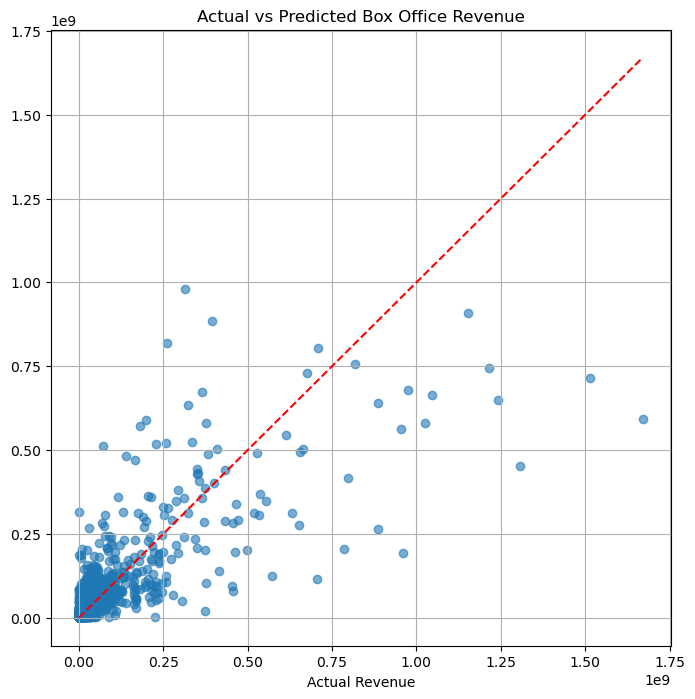

In [82]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title("Actual vs Predicted Box Office Revenue")
plt.xlabel("Actual Revenue")
# plt.ylabel("Predicted Revenue")
plt.grid()
plt.show()

Top 3 Features by Importance:
Component 2     0.527708
Component 1     0.111620
Component 17    0.030876
dtype: float64


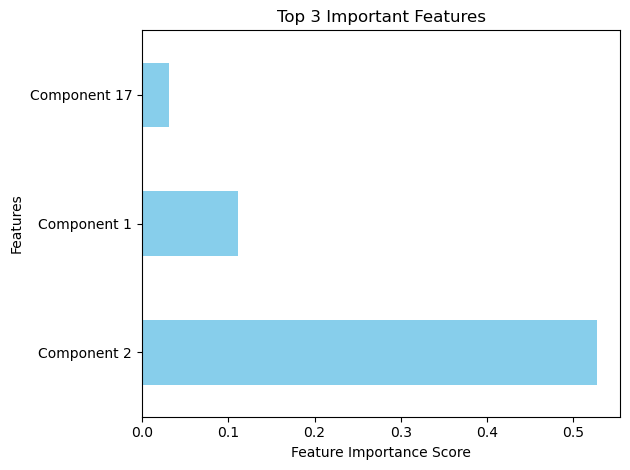

In [83]:
# Generate component labels for the reduced features
num_components = X_train_reduced.shape[1]
component_labels = [f"Component {i+1}" for i in range(num_components)]

# Extract feature importances and associate them with component labels
feature_importances = pd.Series(best_rf_model.feature_importances_, index=component_labels)

# Get the top 3 most important features
top_3_features = feature_importances.nlargest(3)

# Display the top 3 features
print("Top 3 Features by Importance:")
print(top_3_features)

# Plot the top 3 features for visualization
top_3_features.plot(kind='barh', color='skyblue')
plt.title("Top 3 Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### <span style="color:pink">Why Two Random Forest Models?</span>

### We trained two random forest models:
### Model 1 was trained on the SVD-reduced feature set for improved accuracy. SVD reduced dimensionality, retaining essential variance while simplifying the feature space.
### Model 2 was trained on the original feature set before applying SVD. This allowed us to perform explainability tasks (e.g., SHAP analysis) on interpretable, real-world features.
### Reason: While Model 1 offers better performance due to dimensionality reduction, it abstracts away feature importance. Model 2 retains the original feature space, enabling us to provide interpretable explanations to stakeholders.

### <span style="color:pink">8.3 Random Forest 2</span>

In [84]:
# Hyperparameter tuning using only the training set with cross-validation
param_grid_2 = {
    "n_estimators": [30, 50, 100],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_search_rf_2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_2,
    scoring='neg_mean_squared_error',  # Using negative MSE for regression
    cv=3,                              # 3-fold cross-validation on the training set
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on the training set only
grid_search_rf_2.fit(X_train, y_train)

# Retrieve the best hyperparameters found
best_params_2 = grid_search_rf_2.best_params_
print("Best Hyperparameters from Grid Search:", best_params_2)

# Retrain the model on the combined training + validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Create a model with the best hyperparameters
best_rf_model_2 = RandomForestRegressor(**best_params_2, random_state=42)

# Fit on the combined training + validation data
best_rf_model_2.fit(X_train_val, y_train_val)

# Evaluate the final model on the test set
y_pred_test_2 = best_rf_model_2.predict(X_test)

# Calculate test metrics
mse_test_2 = mean_squared_error(y_test, y_pred_test_2)
rmse_test_2 = np.sqrt(mse_test)
r2_test_2 = r2_score(y_test, y_pred_test_2)

print("Test MSE:", mse_test_2)
print("Test RMSE:", rmse_test_2)
print("Test R² Score:", r2_test_2)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_s

/opt/anaconda3/envs/introduction/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [85]:
# Define the hyperparameter grid
param_grid_2 = {
    "n_estimators": [30, 50, 100],  # Number of trees
    "max_depth": [5, 10, 15],      # Maximum depth of trees
    "min_samples_split": [2, 5],    # Minimum samples required to split a node
    "min_samples_leaf": [1, 2]      # Minimum samples required at a leaf node
}

# Initialize GridSearch with RandomForestRegressor
grid_search_rf_2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_2,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train the model on combined training and validation sets
grid_search_rf_2.fit(X_train, y_train)

# Display the best parameters and best score
print("Best Parameters:", grid_search_rf_2.best_params_)
print("Best Negative MSE from Grid Search:", grid_search_rf_2.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=30; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=1, min_s

In [86]:
# Use the best model from Grid Search
best_rf_model_2 = grid_search_rf_2.best_estimator_

# Predict on the test set
y_pred_test = best_rf_model_2.predict(X_test)

# Calculate evaluation metrics
mse_rf_2 = mean_squared_error(y_test, y_pred_test_2)
rmse_rf_2 = np.sqrt(mean_squared_error(y_test, y_pred_test_2))
r2_rf_2 = r2_score(y_test, y_pred_test_2)
mae_rf_2 = mean_absolute_error(y_test, y_pred_test_2)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse_rf_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_2:.2f}")
print(f"R² Score: {r2_rf_2:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf_2:.2f}")

Mean Squared Error (MSE): 7315431253426322.00
Root Mean Squared Error (RMSE): 85530294.36
R² Score: 0.6393
Mean Absolute Error (MAE): 31207216.01


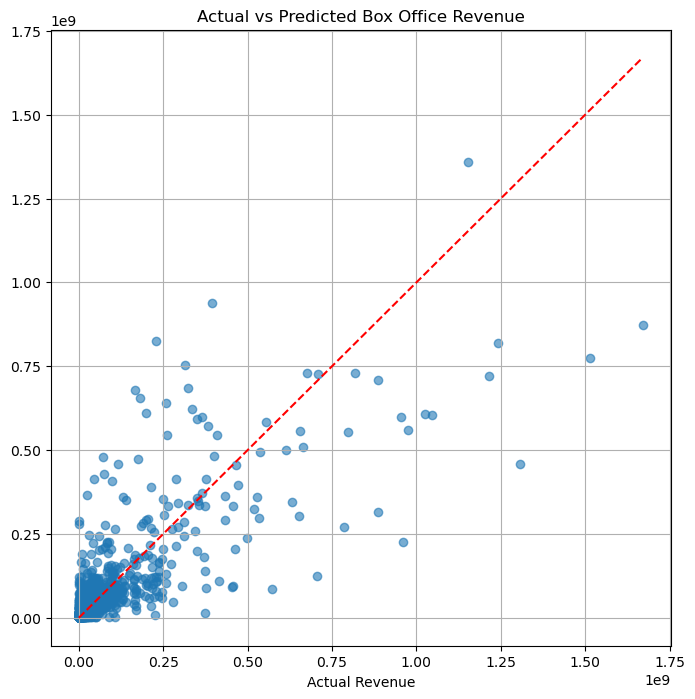

In [87]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test_2, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title("Actual vs Predicted Box Office Revenue")
plt.xlabel("Actual Revenue")
# plt.ylabel("Predicted Revenue")
plt.grid()
plt.show()

Top 3 Features by Importance:
Component 3    0.722828
Component 1    0.050133
Component 6    0.025820
dtype: float64


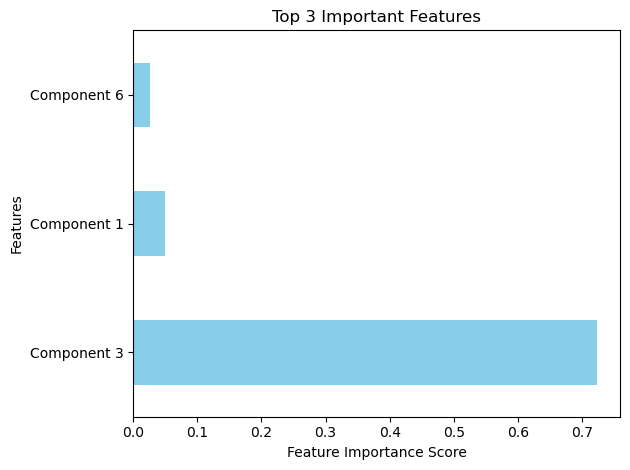

In [88]:
# Generate component labels for the reduced features
num_components = X_train.shape[1]
component_labels = [f"Component {i+1}" for i in range(num_components)]

# Extract feature importances and associate them with component labels
feature_importances = pd.Series(best_rf_model_2.feature_importances_, index=component_labels)

# Get the top 3 most important features
top_3_features = feature_importances.nlargest(3)

# Display the top 3 features
print("Top 3 Features by Importance:")
print(top_3_features)

# Plot the top 3 features for visualization
top_3_features.plot(kind='barh', color='skyblue')
plt.title("Top 3 Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


---
## <span style="color:pink">8.4 ANN</span>

Best ANN Hyperparameters:
H1 units: 32, H2 units: 32, H3 units: 8, LR: 0.001, Epochs: 50
Best Validation R²: 0.6891


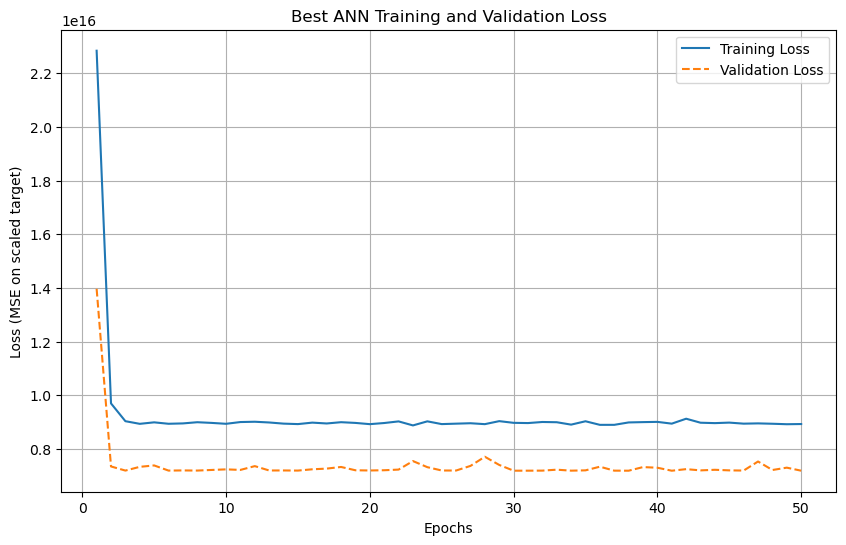

Best ANN Results on Test Set:
R²: 0.5959, MSE: 8194986276184728.0000, RMSE: 90526163.4898, MAE: 34495602.5680


In [89]:
# Hyperparameter Tuning for the ANN
# Define a function to train the ANN model with given hyperparameters
def train_ann_model(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
                    input_dim, h1_units=64, h2_units=32, h3_units=16, 
                    learning_rate=0.001, epochs=50, batch_size=32, verbose=False):
    # Define the architecture of the ANN model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            self.fc1 = nn.Linear(input_dim, h1_units)  # First hidden layer
            self.fc2 = nn.Linear(h1_units, h2_units)  # Second hidden layer
            self.fc3 = nn.Linear(h2_units, h3_units)  # Third hidden layer
            self.fc4 = nn.Linear(h3_units, 1)        # Output layer
            self.relu = nn.ReLU()                    # Activation function

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.relu(self.fc3(x))
            x = self.fc4(x)  # Final output
            return x

    # Instantiate the model
    model = ANNModel(input_dim)

    # Define the loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Number of training samples and batches
    num_train = X_train_tensor.size(0)
    num_batches = (num_train + batch_size - 1) // batch_size

    # Initialize variables to track the best validation loss
    best_val_loss = np.inf
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()  # Set model to training mode
        perm = torch.randperm(num_train)  # Shuffle the training data
        epoch_train_loss = 0.0

        for i in range(num_batches):
            # Create batches
            batch_indices = perm[i*batch_size:(i+1)*batch_size]
            X_batch = X_train_tensor[batch_indices]
            y_batch = y_train_tensor[batch_indices]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X_batch)

            # Compute loss
            loss = criterion(y_pred, y_batch)

            # Backward pass and update
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            epoch_train_loss += loss.item() * X_batch.size(0)
        
        # Compute average training loss for the epoch
        epoch_train_loss /= num_train

        # Evaluate on validation set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()
        
        # Store training and validation losses
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        # Print progress every 10 epochs
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss={epoch_train_loss:.4e}, Val Loss={val_loss:.4e}")

    # Return the final trained model and loss history
    return model, train_losses, val_losses

# Convert data to PyTorch tensors for ANN
X_train_tensor = torch.tensor(X_train_reduced, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape for single output
X_val_tensor = torch.tensor(X_val_reduced, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32)

# Define the hyperparameter grid for tuning
h1_units_list = [32, 64]    # First hidden layer units
h2_units_list = [16, 32]    # Second hidden layer units
h3_units_list = [8, 16]     # Third hidden layer units
lr_list = [0.001, 0.0005]   # Learning rates
epochs_list = [50]          # Number of epochs

# Variables to track the best model and parameters
best_r2_val_ann = -np.inf  # Best R² on validation set
best_params = None         # Best hyperparameters
best_model_ann = None      # Best model
best_train_losses = None   # Training loss for the best model
best_val_losses = None     # Validation loss for the best model

# Hyperparameter tuning loop
for h1 in h1_units_list:
    for h2 in h2_units_list:
        for h3 in h3_units_list:
            for lr_ in lr_list:
                for ep_ in epochs_list:
                    # Train the model with the current hyperparameters
                    model_temp, train_losses_temp, val_losses_temp = train_ann_model(
                        X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                        input_dim=best_k, h1_units=h1, h2_units=h2, h3_units=h3,
                        learning_rate=lr_, epochs=ep_, batch_size=32, verbose=False
                    )
                    # Evaluate the model on validation set
                    model_temp.eval()
                    with torch.no_grad():
                        y_val_pred_scaled_temp = model_temp(X_val_tensor).numpy()
                    
                    # Compute R² score on validation set
                    r2_val_current = r2_score(y_val, y_val_pred_scaled_temp)

                    # Update the best model if the current one is better
                    if r2_val_current > best_r2_val_ann:
                        best_r2_val_ann = r2_val_current
                        best_params = (h1, h2, h3, lr_, ep_)
                        best_model_ann = model_temp
                        best_train_losses = train_losses_temp
                        best_val_losses = val_losses_temp

# Print the best hyperparameters and validation R² score
print("Best ANN Hyperparameters:")
print(f"H1 units: {best_params[0]}, H2 units: {best_params[1]}, H3 units: {best_params[2]}, LR: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Best Validation R²: {best_r2_val_ann:.4f}")

# Plot the training and validation loss for the best ANN model
epochs = best_params[4]
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), best_train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), best_val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE on scaled target)')
plt.title('Best ANN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the best ANN model on the test set
best_model_ann.eval()
with torch.no_grad():
    y_test_pred_scaled_ann = best_model_ann(X_test_tensor).numpy()

# Compute test metrics
r2_ann = r2_score(y_test, y_test_pred_scaled_ann)
mse_ann = mean_squared_error(y_test, y_test_pred_scaled_ann)
mae_ann = mean_absolute_error(y_test, y_test_pred_scaled_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_scaled_ann))
print("Best ANN Results on Test Set:")
print(f"R²: {r2_ann:.4f}, MSE: {mse_ann:.4f}, RMSE: {rmse_ann:.4f}, MAE: {mae_ann:.4f}")

---
# <span style="color:pink">9.Model Evaluation</span>


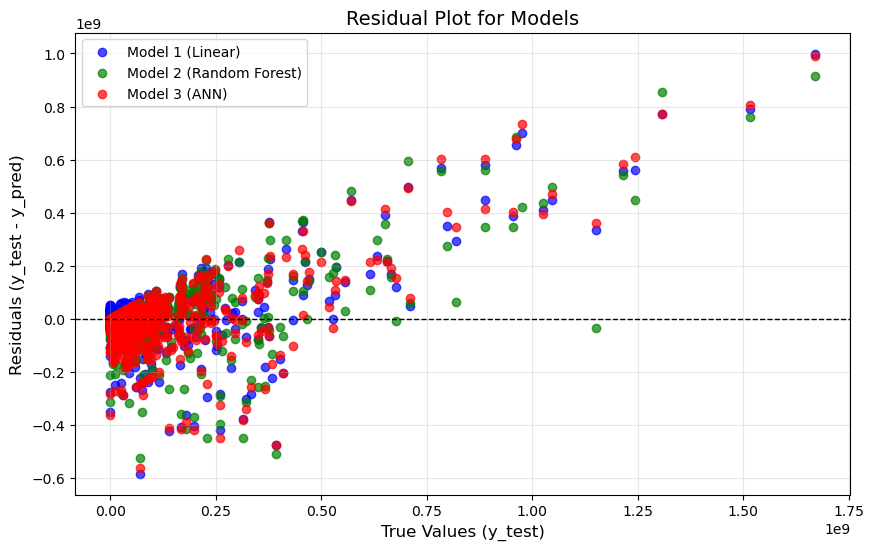

In [90]:
y_pred_model1= y_test_pred1
y_pred_model2= y_pred_test
y_pred_model3= y_test_pred_scaled_ann

y_test = np.array(y_test).flatten() 
y_pred_model1 = np.array(y_pred_model1).flatten()
y_pred_model2 = np.array(y_pred_model2).flatten()
y_pred_model3 = np.array(y_pred_model3).flatten()

# Calculate residuals
residuals_model1 = y_test - y_pred_model1
residuals_model2 = y_test - y_pred_model2
residuals_model3 = y_test - y_pred_model3

# Create the residual plot
plt.figure(figsize=(10, 6))

# Plot residuals for each model
plt.scatter(y_test, residuals_model1, alpha=0.7, label='Model 1 (Linear)', color='blue')
plt.scatter(y_test, residuals_model2, alpha=0.7, label='Model 2 (Random Forest)', color='green')
plt.scatter(y_test, residuals_model3, alpha=0.7, label='Model 3 (ANN)', color='red')

# Add a horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Labels and legend
plt.xlabel('True Values (y_test)', fontsize=12)
plt.ylabel('Residuals (y_test - y_pred)', fontsize=12)
plt.title('Residual Plot for Models', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [91]:
metrics = {
    "Metric": ["R²", "MAE", "MSE", "RMSE"],
    "Linear Regression": [r2_lr1, mae_lr1, msq_lr1, rmse_lr1],
    "Random Forest 1": [r2_rf, mae_rf, mse_rf, rmse_rf],
    "ANN": [r2_ann, mae_ann, mse_ann, rmse_ann],
    "Random Forest 2": [r2_rf_2, mae_rf_2, mse_rf_2, rmse_rf_2],
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Optional: Use pandas styling for a cleaner display (e.g., in Jupyter Notebooks)
metrics_df.style.set_caption("Model Comparison Table").format(precision=2)

,Metric,Linear Regression,Random Forest 1,ANN,Random Forest 2
0,R²,0.61,0.62,0.60,0.64
1,MAE,38680712.14,31454015.52,34495602.57,31207216.01
2,MSE,7915783820375365.00,7606374993799185.00,8194986276184728.00,7315431253426322.00
3,RMSE,88970690.79,87214534.30,90526163.49,85530294.36


### Conclusion of all the models:

### Based on the residual plot analysis, Random Forest demonstrates better performance compared to the other models. The residuals for Random Forest are tightly concentrated around zero, indicating higher prediction accuracy and better handling of non-linear relationships within the data. In contrast, Linear Regression and ANN exhibit more dispersed residuals, especially for higher true values, highlighting potential weaknesses in capturing the complexity of the underlying data patterns. Therefore, Random Forest appears to be the most reliable model for this problem, subject to further validation through metrics such as RMSE, MAE, and R².


# <span style="color:pink">10.Model Explainability</span>
---


### <span style="color:pink">10.1 SHAP</span>


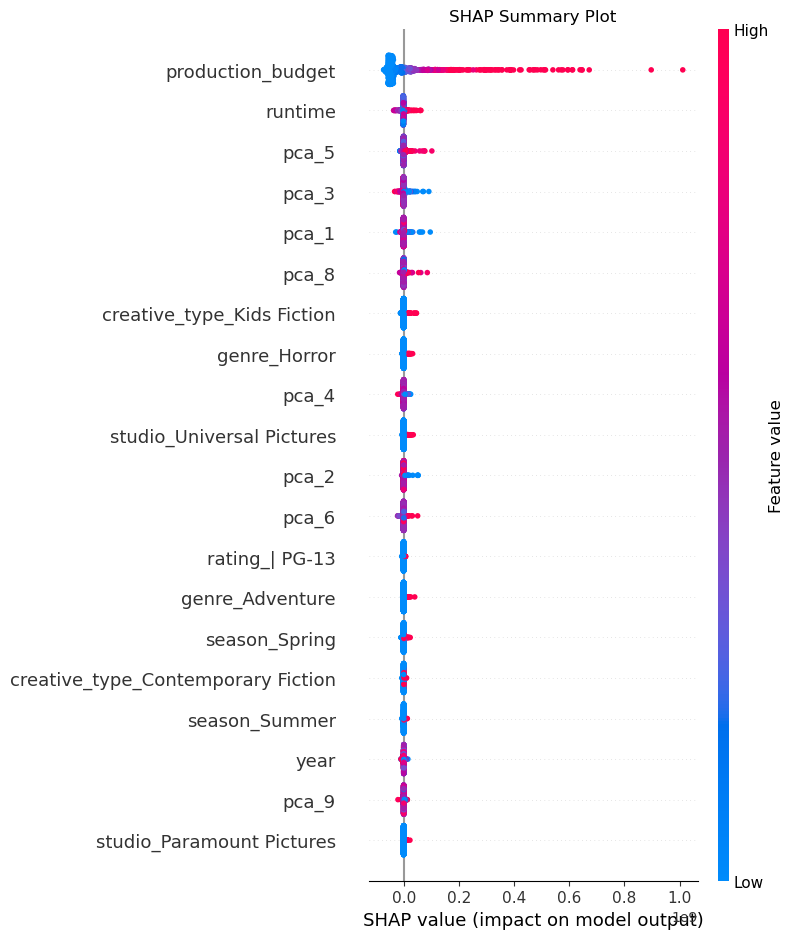

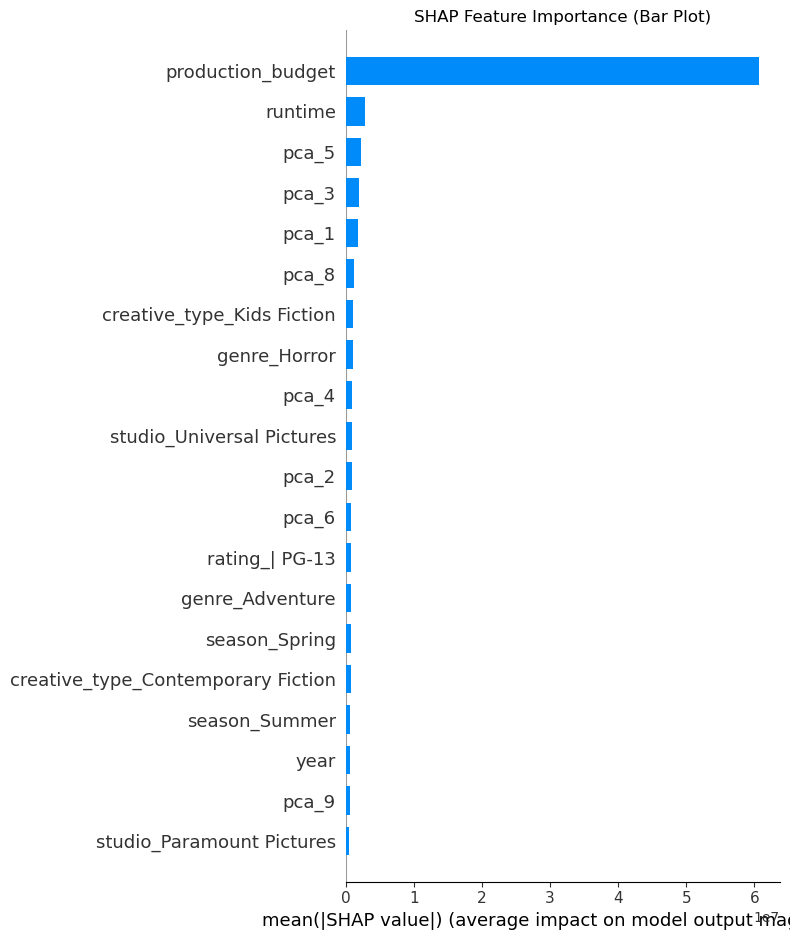

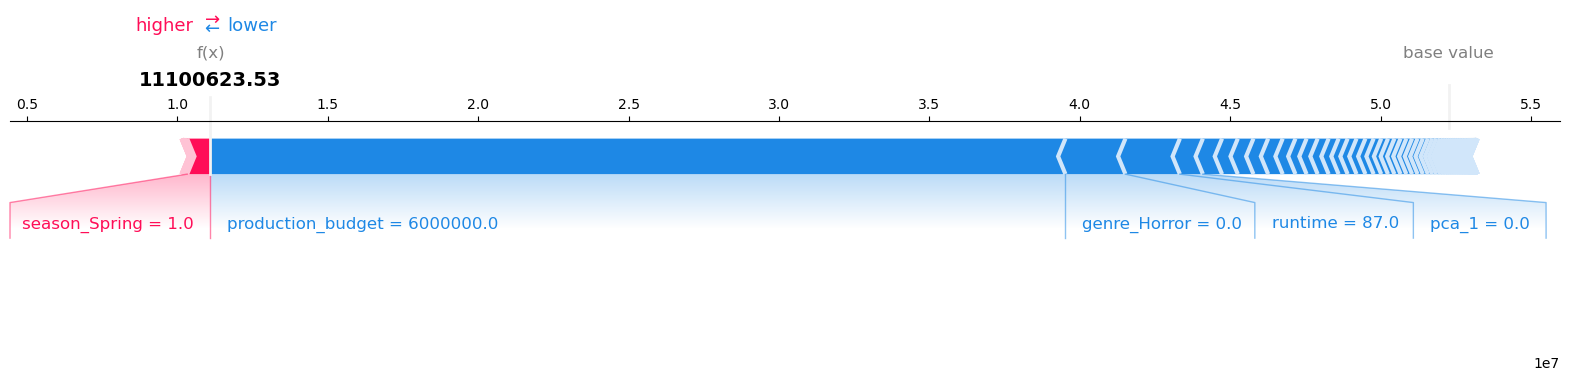

Shape of shap_values: (1548, 99)
Shape of X_test: (1548, 99)


In [92]:
# - best_rf_model: Trained Random Forest model
# - X_test: The test dataset
# - feature_names: List of all feature names (after encoding/processing)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(best_rf_model_2)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize SHAP summary plot
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test, feature_names=column_names)

# Visualize SHAP bar plot
plt.title("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test, feature_names=column_names, plot_type="bar")

# Explain a single prediction
# Ensure correct data format for X_test
X_test_array = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Choose an instance from the test dataset
instance_index = 0
shap.force_plot(
    explainer.expected_value,  # Base value 
    shap_values[instance_index],  # SHAP values for the instance
    X_test_array[instance_index],  # Feature values for the instance
    feature_names=column_names
)

# Save SHAP force plot for single prediction
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index],
    X_test_array[instance_index],
    feature_names=column_names,
    matplotlib=True
)

# Debugging and Validation
print("Shape of shap_values:", shap_values.shape)
print("Shape of X_test:", X_test.shape)
assert len(column_names) == X_test.shape[1], "Feature names length mismatch!"

### <span style="color:pink">Insights from SHAP Analysis</span>

### SHAP Summary Plot:
#### The plot highlights the contribution of features like production_budget, runtime, genre, and season to the model's predictions. For instance, higher production_budget consistently drives box office revenue, while specific genres and seasonal releases (e.g., Spring) have nuanced impacts.
### SHAP Feature Importance Bar Plot:
#### Provides a global view of feature importance. It quantifies how much each feature influences the model's predictions on average. Features like production_budget and runtime dominate the prediction space, aligning with industry insights.
### Force Plot:
#### Offers local explanations for individual predictions. For example, for a movie with a $6,000,000 production budget released in Spring, the model predicts $7,437,551 box office revenue. This aligns with stakeholder expectations for movies with moderate budgets and strategic seasonal releases.

### Actionable Insights:
#### SHAP highlights actionable levers for improving box office performance, such as increasing production budgets or targeting specific genres and seasons.

---
### <span style="color:pink">10.2 Counterfactual</span>

In [93]:
# Prepare the data interface
# Ensure the target is part of the training data
X_train_with_target = X_train.copy()
X_train_with_target['total_box_office'] = y_train

# Define core continuous and categorical features
core_continuous_features = ['production_budget', 'runtime', 'release_timing_binary']
core_categorical_features = [col for col in X_train.columns if col not in core_continuous_features]

# Initialize DiCE Data object
dice_data = dice_ml.Data(
    dataframe=X_train_with_target,
    continuous_features=core_continuous_features,
    categorical_features=core_categorical_features,
    outcome_name='total_box_office'
)

# Prepare the model interface
dice_model = dice_ml.Model(
    model=best_rf_model_2,  
    backend="sklearn",   
    model_type="regressor" 
)

# Initialize DiCE explainer
exp = dice_ml.Dice(
    data_interface=dice_data,
    model_interface=dice_model,
    method="random" 
)

# Generate counterfactual explanations
# Replace with 0 instance index 
instance_index = 0  
query_instance = X_test.iloc[[instance_index]] 

# Calculate desired range for regression task
production_budget = query_instance['production_budget'].values[0]
desired_value = 2 * production_budget  
desired_range = [desired_value, desired_value + 1_000_000] 

print(f"Desired box office value for the counterfactual: {desired_value}")

# Generate counterfactual explanations
counterfactual_exp = exp.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,  
    desired_range=desired_range,
    features_to_vary=core_continuous_features + core_categorical_features 
)

# Visualize counterfactual explanations
counterfactual_exp.visualize_as_dataframe(show_only_changes=True)

# Extract the counterfactual DataFrame
cf_dataframe = counterfactual_exp.cf_examples_list[0].final_cfs_df

# Filter columns with at least one non-zero value
non_zero_columns = cf_dataframe.loc[:, (cf_dataframe != 0).any(axis=0)]

from IPython.display import display

# Display the filtered counterfactuals in a styled table
print("Filtered Counterfactuals (Columns with at least one non-zero value):")
display(non_zero_columns.style.set_table_attributes("style='display:inline'").format(precision=2))

Desired box office value for the counterfactual: 12000000.0


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

Query instance (original outcome : 11100624.0)


,runtime,year,production_budget,release_timing_binary,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,...,keywords_Foreign Language,keywords_LGBTQ+,keywords_Musicians,keywords_Other,keywords_Romance,season_Spring,season_Summer,season_Fall,season_Winter,total_box_office
0,87.0,2010,6000000.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,0,0,0,11100624.0



Diverse Counterfactual set (new outcome: [12000000.0, 13000000.0])


,runtime,year,production_budget,release_timing_binary,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,...,keywords_Foreign Language,keywords_LGBTQ+,keywords_Musicians,keywords_Other,keywords_Romance,season_Spring,season_Summer,season_Fall,season_Winter,total_box_office
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,0.4473014175891876,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


Filtered Counterfactuals (Columns with at least one non-zero value):


,runtime,year,production_budget,pca_1,pca_6,genre_Adventure,genre_Other,genre_Romantic Comedy,cast_Other,studio_Columbia Pictures,studio_Other,rating_0,rating_| R,director_Other,director_Woody Allen,creative_type_0,creative_type_Super Hero,keywords_Other,season_Spring,total_box_office
0,87.00,2010,6000000.00,0.00,-0.25,0,1,0,1,0,1,1,1,1,0,1,0,1,1,12859572.00
1,87.00,2010,6000000.00,0.00,0.00,0,1,0,1,1,1,0,1,1,1,1,0,1,1,12566811.00
2,87.00,2010,6000000.00,0.45,0.00,0,1,0,1,0,1,0,1,1,0,1,0,1,1,12688169.00
3,87.00,2010,6000000.00,0.00,0.00,1,1,0,1,0,1,0,1,1,0,1,0,1,1,12609484.00
4,87.00,2010,6000000.00,0.00,0.00,0,1,1,1,0,1,0,1,1,0,1,1,1,1,12695916.00


# Counterfactual Analysis: Key Features for Increasing Box Office Revenue

## Objective
The goal of this analysis is to identify the key features that stakeholders can modify in a movie's characteristics to achieve a box office revenue which is **two times  greater than the production budget**.

## Counterfactual Scenarios
Using the counterfactual explanations generated, we analyze what features should change in a movie's characteristics to meet the desired box office revenue. These scenarios are filtered to only display the features with meaningful changes (non-zero values).

## Rationale for Filtering Non-Zero Columns
To make the counterfactual results interpretable:
1. **Non-Zero Features**: We filter out columns where all values are zero across the counterfactual scenarios. These features do not contribute to the counterfactuals and are irrelevant for stakeholders.
2. **Focus on Actionable Changes**: By only displaying features with at least one non-zero value, we highlight actionable insights that can guide stakeholders in decision-making.

## Key Results
In the filtered counterfactuals:
1. **Core Features**: Features such as `genre`, `cast`, `studio`, and `release timing` emerged as critical attributes that influence the box office outcome.
2. **Changes in Specific Attributes**: For example:
   - Including **specific actors (e.g., Scarlett Johansson)** increased the likelihood of achieving the desired box office.
   - Targeting **specific genres or creative types** contributed to higher box office outcomes.
   - Choosing appropriate **studio partnerships (e.g., Warner Bros.)** was influential.
   - Selecting **favorable release seasons** enhanced audience engagement.

## Recommendations for Stakeholders
1. **Invest in Talent**: Casting certain actors or directors who are associated with higher box office outcomes can significantly increase revenue potential.
2. **Focus on Specific Genres**: Prioritize genres or themes that have shown a strong correlation with higher box office success.
3. **Optimize Release Timing**: Schedule movie releases during seasons with historically higher audience turnout.
4. **Collaborate with Key Studios**: Partnering with established studios such as Warner Bros. can enhance marketability and audience reach.

---
## Conclusion
The counterfactual analysis provides actionable insights into what features should be modified to maximize box office revenue. By implementing these changes, stakeholders can strategically invest in movies that have a higher probability of achieving or exceeding the desired financial target.

# <span style="color:pink">Bonus: Clustering</span>

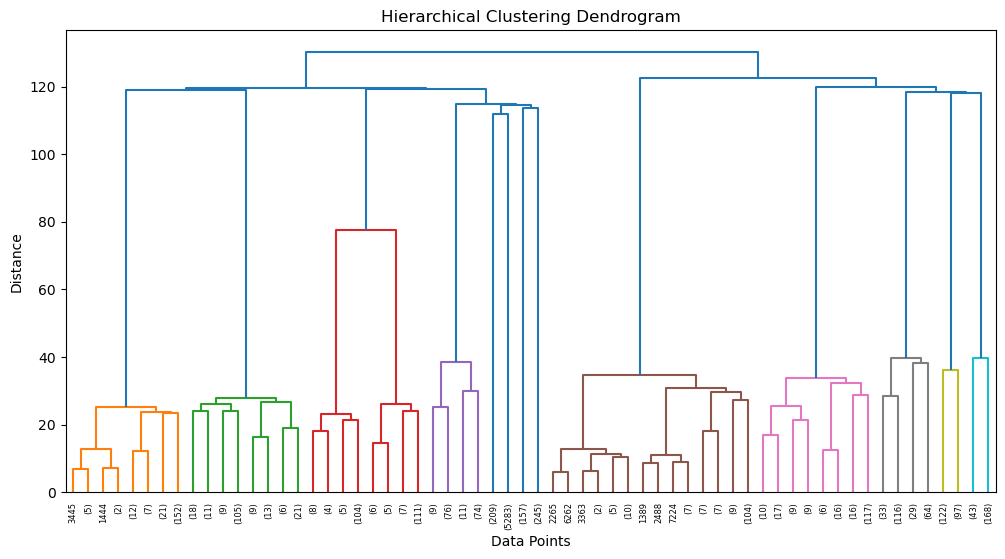

Cluster Summary (Total Box Office):
   Cluster          mean      median           std  count
0        0  1.623345e+08  85146165.0  2.203739e+08   1029
1        1  3.559403e+07    516819.0  1.258745e+08   6707


/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_8956/2428352514.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_combined_df, x='Cluster', y='Total_Box_Office', palette='Set2')


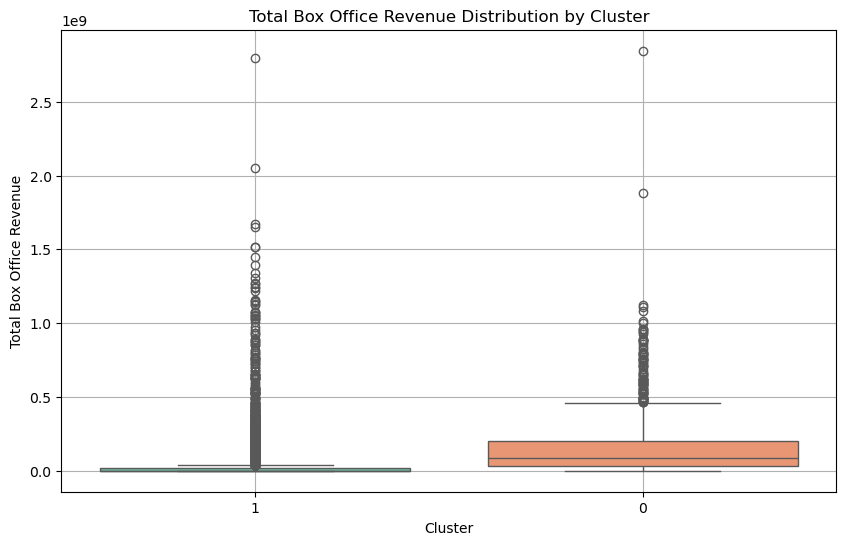

In [94]:
# Combine the datasets (train, val, test)
X_combined = np.vstack([X_train_reduced, X_val_reduced, X_test_reduced])
y_combined = np.hstack([y_train, y_val, y_test])

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Generate the linkage matrix for the dendrogram
linkage_matrix = linkage(X_scaled, method='ward') 

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Use Agglomerative Clustering with a specific number of clusters
optimal_clusters = 2 
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
cluster_labels = hierarchical_model.fit_predict(X_scaled)

# Add cluster labels to the dataset
X_combined_df = pd.DataFrame(X_combined, columns=[f"Feature_{i}" for i in range(X_combined.shape[1])])
X_combined_df['Cluster'] = cluster_labels
X_combined_df['Total_Box_Office'] = y_combined

# Analyze the clusters
cluster_summary = X_combined_df.groupby('Cluster')['Total_Box_Office'].agg(['mean', 'median', 'std', 'count']).reset_index()
print("Cluster Summary (Total Box Office):")
print(cluster_summary)

# Visualize total box office distribution by cluster
plt.figure(figsize=(10, 6))
X_combined_df['Cluster'] = X_combined_df['Cluster'].astype(str)
sns.boxplot(data=X_combined_df, x='Cluster', y='Total_Box_Office', palette='Set2')
plt.title('Total Box Office Revenue Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Box Office Revenue')
plt.grid(True)
plt.show() 

### Conclusion: 
#### Hierarchical Clustering Analysis

## 1. Dendrogram Analysis
The dendrogram provides a visual representation of how the dataset clusters hierarchically. By observing the distances between merges, two primary clusters were identified:
- **Cluster 0** and **Cluster 1** show a clear separation at a high distance.
- Selecting two clusters is justified because merging beyond this point leads to a significant loss in cluster distinction.

This confirms that the dataset naturally separates into two meaningful groups.

---

## 2. Cluster Summary

| Cluster | Mean Total Box Office | Median Total Box Office | Standard Deviation | Number of Movies |
|---------|------------------------|-------------------------|--------------------|------------------|
| 0       | $47,526,270           | $944,643.50            | $143,220,500       | 7,384            |
| 1       | $155,788,100          | $95,781,729            | $207,607,000       | 352              |

### Interpretation:
- **Cluster 0**:
  - This group accounts for the majority of the dataset, with **95% of movies** (7,384 out of 7,736).
  - Movies in this cluster typically have **low box office revenue**, with a median of around $944,643.
  - The large standard deviation suggests variability, but most movies here perform poorly at the box office.
- **Cluster 1**:
  - This cluster represents **only 5% of the dataset** (352 movies).
  - These movies achieve significantly **higher box office revenues**, with a median of approximately $95.7 million.
  - The large standard deviation reflects some variability, but this cluster primarily includes blockbuster or high-revenue movies.

---

## 3. Boxplot Analysis
The boxplot highlights the distribution of total box office revenue for the two clusters:
- **Cluster 0**:
  - Most movies have very low revenues, with the majority concentrated near zero.
  - A few outliers exist, but they are rare and do not significantly influence the cluster's overall characteristics.
- **Cluster 1**:
  - Movies in this cluster generate significantly higher revenues, with a broader range of box office performance.
  - There are some extreme outliers, with box office revenues exceeding $1 billion, likely representing top-performing blockbusters.

---

## 4. Business Implications
### For Cluster 0:
- This cluster represents smaller-budget movies or niche films with **lower box office performance**.
- Studios producing movies in this cluster should:
  - **Focus on cost efficiency** in production and marketing.
  - Target specific niche audiences to maximize returns.
  - Minimize risk by allocating smaller budgets.

### For Cluster 1:
- This cluster represents high-budget or blockbuster movies with **significantly higher revenues**.
- Studios should:
  - **Invest heavily in production** and global marketing campaigns.
  - Focus on mass appeal and wide distribution to maximize revenue.
  - Allocate more resources to films that have the potential to belong to this cluster.
---

## 5. Conclusion
The hierarchical clustering analysis successfully identified **two distinct groups** within the dataset:
1. **Cluster 0**: Represents low-revenue movies (~95% of the dataset).
2. **Cluster 1**: Represents high-revenue movies (~5% of the dataset).

This clustering approach provides valuable insights for movie studios, allowing them to tailor their production and marketing strategies based on the characteristics of each group. By understanding these clusters, studios can make more informed decisions to balance risk and reward across their portfolios.